# Observable 5

En este notebook se describen los análisis realizados sobre los espacios de parametros derivados del observable 5.


* esp 1: $\dfrac{\rho^{450}_{\mu}}{log(\sqrt{S_{rad}})}$ y $X^{Rd}_{max}$


* esp 2: $\dfrac{\rho^{450}_{\mu}}{X^{Rd}_{max} \cdot log(\sqrt{S_{rad}})}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$ y $ log(\sqrt{S_{rad}})$


* esp 4: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, $ log(\sqrt{S_{rad}})$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, $ log(\sqrt{S_{rad}})$, E$_{true}$ y $\theta$


* esp 3: $\rho^{450}_{\mu}$, $X^{Rd}_{max}$, $ log(\sqrt{S_{rad}})$, E$_{true}$, $\theta$ y estaciones de radio.

In [1]:
#Librerias importantes
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
import os

In [2]:
def MeritFactor(v1, v2):
    #Calculo de MF
    muF, stdF = norm.fit(v1)
    muP, stdP = norm.fit(v2)
    #muF, stdF = np.mean(v1), np.std(v1)
    #muP, stdP = np.mean(v2), np.std(v2)
    MF = np.abs(muF - muP) / (np.sqrt(pow(stdF,2) + pow(stdP,2)))
    return MF

In [3]:
def boostMF(v1, v2):
    vv=[]
    size=int(len(v1))
    for i in range(20000):
        #np.random.seed(seed=None)
        samplexF = np.random.choice(v1, size=int(size*0.90), replace=True)
        samplexP = np.random.choice(v2, size=int(size*0.90), replace=True)
        MF = MeritFactor(np.array(samplexP), np.array(samplexF))
        vv.append(np.abs(MF))
    
    avg, std = norm.fit(vv)
    return "%.2f"%avg, "%.2f"%std

In [4]:
# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

# Where to save the figures
PROJECT_ROOT_DIR = "/home/csarmiento/MEGA/phd_mega/analisisDeDatos/ML_MassComp/"
#CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, figsize=(10,8))

In [5]:
#Función para calcular el accuracy
def accuracy(X, y, model):
    a=accuracy_score(y, model.predict(X))
    return a

In [6]:
#Función para calcular el accuracy via Cross-Val score
#Esto nos sirve para validar nuestro modelo sin usar los datos de test
def crossAccuracy(X, y, model):
    scoresGauTrain= cross_val_score(model, X, y, cv=10, scoring="accuracy");
    pres = cross_val_score(model, X, y, cv=10, scoring="precision");
    recl = cross_val_score(model, X, y, cv=10, scoring="recall");
    F1 = 2/((1/pres)+(1/recl))
    print("Accuracy: ", scoresGauTrain.mean(), scoresGauTrain.std())
    print("presicion: ", pres.mean(), pres.std())
    print("recall: ", recl.mean(), recl.std())
    print("F1_score: ", F1.mean(), F1.std())

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

def auc_cv(X, y, model):
    model = model
    X = np.array(X)
    y = np.array(y)
    random_state = np.random.RandomState(369)

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)

    tprs = []
    for i, (train, train) in enumerate(cv.split(X, y)):
        viz = roc_auc_score(y[train], model.predict_proba(X[train])[:, 1])
        tprs.append(viz)

    print(np.mean(tprs), np.std(tprs))

In [8]:
"""
Matriz de Confusion
Con MC podemos ver en detalle el comportamiento del modelo y saber cuantos eventos fueron mal clasificados.
Esta podría ser una mirada más realista que el accuracy.

>>> La precisión es definida como el ratio entre verdaderos positivos y número total 
de positivos predichos. Esto nos dice la fracción de los eventos que el modelo nos 
dice que son de la clase, realmente lo son.

>>> El recall o exhaustividad es definida como el es el ratio entre los verdaderos positivos 
y la suma de los verdaderos positivos y los falsos negativos. Esto nos dice la fracción
de los elementos de la clase encontró.
"""
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def mconfusion(X, y, model):
    aux_pred = cross_val_predict(model, X, y, cv=10)
    cm = confusion_matrix(y, aux_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pres=tp/(tp + fp)
    exha=tp/(tp + fn)
    print("Matriz de confusión, \n"), print(cm), print("precisión: ", pres), print("exhaustividad: ", exha)

In [9]:
#Funcion para calcular la energia con GeoCeLDF
def GeoCeEnergy(RadEnergy, Alpha):
    d = 2.3137 * 1e14   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    c = 0.505
    E = d * pow(RadEnergy / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c)
    #return list(E)
    return np.array(E)
 
def GeoCeEnergyError(RadEnergy, RadEnergyError, Alpha):
    c = 0.505   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    errorE = pow(1 / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c) * pow(RadEnergy, c - 1) * RadEnergyError
    return errorE

In [10]:
#A partir de aquí python sabe en que carpeta se encuentran los datos
os.chdir("/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData/")
os.getcwd()

'/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData'

In [11]:
#Cargando datos
df= pd.read_csv(r"CutEvents_IronRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")
dp= pd.read_csv(r"CutEvents_ProtonRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")

In [12]:
print(df.shape, dp.shape)

(305, 59) (305, 59)


In [13]:
#angulo alfa
AlphaFe=df['lorentz angle']
AlphaFe=np.array(AlphaFe)
AlphaPr=dp['lorentz angle']
AlphaPr=np.array(AlphaPr)

#radiation energy
RadEGeoCeFe=df['GeoCe Erad']
RadEGeoCeFe=np.array(RadEGeoCeFe)
RadEGeoCePr=dp['GeoCe Erad']
RadEGeoCePr=np.array(RadEGeoCePr)

#radiation energy error
RadEGeoCeFe_err=df['GeoCe Erad Error']
RadEGeoCeFe_err=np.array(RadEGeoCeFe_err)
RadEGeoCePr_err=dp['GeoCe Erad Error']
RadEGeoCePr_err=np.array(RadEGeoCePr_err)

#Energia Rd
GeoCeEnergyFe=GeoCeEnergy(RadEGeoCeFe,AlphaFe)
GeoCeEnergyFe_err=GeoCeEnergyError(RadEGeoCeFe, RadEGeoCeFe_err, AlphaFe)
GeoCeEnergyPr=GeoCeEnergy(RadEGeoCePr,AlphaPr)
GeoCeEnergyPr_err=GeoCeEnergyError(RadEGeoCePr,RadEGeoCePr_err, AlphaPr)

df["EnergyRd"] = GeoCeEnergyFe
dp["EnergyRd"] = GeoCeEnergyPr

In [14]:
#Inclusion del target

df["Mu_LogSrad"] = df["N_mu_ref"]/np.log10(np.sqrt(df["GeoCe Erad"]))
dp["Mu_LogSrad"] = dp["N_mu_ref"]/np.log10(np.sqrt(dp["GeoCe Erad"]))

df["LogSrad"] = np.log10(np.sqrt(df["GeoCe Erad"]))
dp["LogSrad"] = np.log10(np.sqrt(dp["GeoCe Erad"]))

df["Mu_LogSrad_Xmax"] = df["N_mu_ref"]/(np.log10(np.sqrt(df["GeoCe Erad"])) * df["GeoCeXmax"])
dp["Mu_LogSrad_Xmax"] = dp["N_mu_ref"]/(np.log10(np.sqrt(dp["GeoCe Erad"])) * dp["GeoCeXmax"])

df["target"] = df["Rd rec success"]
dp["target"] = dp["Rd rec success"]*0

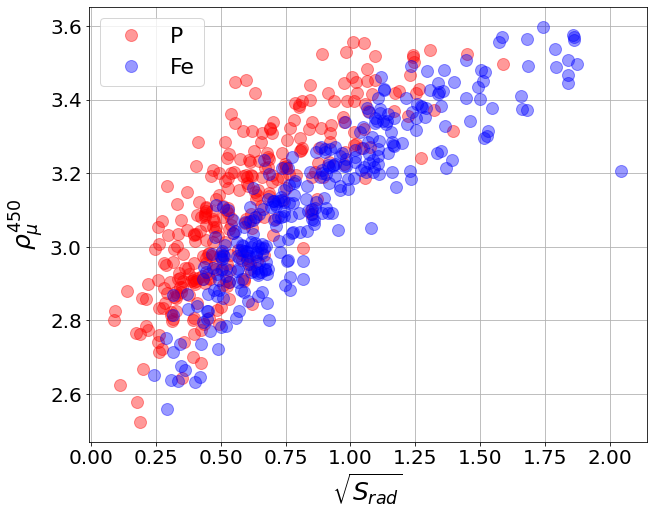

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(dp['N_mu_ref'], np.log10(np.sqrt(df["GeoCe Erad"])), 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(df['N_mu_ref'], np.log10(np.sqrt(dp["GeoCe Erad"])), 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()
plt.show()

<AxesSubplot:>

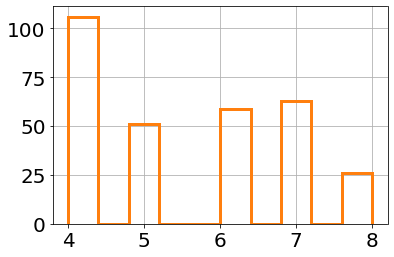

In [16]:
#Iron
df["energy_cut"] = pd.cut(df["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

df["energy_cut"].hist(histtype='step',linewidth=3, label="Energia")

#Proton

dp["energy_cut"] = pd.cut(dp["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

dp["energy_cut"].hist(histtype='step',linewidth=3, label="Energia")

In [17]:
df["energy_cut"].value_counts()

4    106
7     63
6     59
5     51
8     26
Name: energy_cut, dtype: int64

In [18]:
#### Iron

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=224466)
for train_index, test_index in split.split(df, df["energy_cut"]):
    train_set_fe = df.loc[train_index]
    test_set_fe = df.loc[test_index]
    
train_set_fe=train_set_fe.drop(["energy_cut"], axis=1)
test_set_fe=test_set_fe.drop(["energy_cut"], axis=1)
print(train_set_fe.shape, test_set_fe.shape)

(244, 64) (61, 64)


In [19]:
#### Proton

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(dp, dp["energy_cut"]):
    train_set_pr = dp.loc[train_index]
    test_set_pr = dp.loc[test_index]
    
train_set_pr=train_set_pr.drop(["energy_cut"], axis=1)
test_set_pr=test_set_pr.drop(["energy_cut"], axis=1)
print(train_set_pr.shape, test_set_pr.shape)

(244, 64) (61, 64)


In [20]:
### Contanetando data set
f_train = [train_set_fe, train_set_pr]
f_test = [test_set_fe, test_set_pr]

df_train_ = pd.concat(f_train)
df_test_ = pd.concat(f_test)

print(df_train_.shape, df_test_.shape)
df_train_.head()

(488, 64) (122, 64)


,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd,Mu_LogSrad,LogSrad,Mu_LogSrad_Xmax,target
246,104205,3.824250e+17,50.0277,332.231,606.878,449654,6113980.0,1468.62,1,3.718930e+17,...,10.3269,0.625931,0.309216,0,0.342569,2.963127e+17,0.276681,3.074320,0.000453,1
76,101420,7.590210e+17,50.6696,252.789,615.647,448851,6114320.0,1478.28,1,5.112060e+17,...,17.2197,0.964079,0.189909,0,0.304324,5.784101e+17,0.332348,3.352450,0.000496,1
171,102730,6.116010e+17,40.6307,285.853,616.988,449204,6114370.0,1473.42,1,4.199210e+17,...,17.0630,0.588354,0.280413,0,0.328039,4.665071e+17,0.350593,3.271228,0.000524,1
191,103178,3.842740e+17,53.6568,218.822,601.143,450980,6114150.0,1460.45,1,2.665860e+17,...,10.9482,0.000097,2.893310,0,0.445807,3.314039e+17,0.196055,3.122918,0.000343,1
75,101416,9.452550e+17,49.0955,355.084,636.076,449628,6113950.0,1467.00,1,6.682260e+17,...,10.3834,1.490790,0.183751,0,0.765089,7.529746e+17,0.357259,3.448698,0.000596,1


In [21]:
df_train = df_train_.copy()
df_test = df_test_.copy()

In [22]:
#Features

df_train_1 = df_train[["GeoCeXmax", "Mu_LogSrad", "target"]]
df_test_1 = df_test[["GeoCeXmax", "Mu_LogSrad", "target"]]

In [23]:
print(df_train_.shape, df_test_.shape)

(488, 64) (122, 64)


In [24]:
df_train_1.head()

,GeoCeXmax,Mu_LogSrad,target
246,610.506,0.276681,1
76,670.556,0.332348,1
171,669.154,0.350593,1
191,571.015,0.196055,1
75,599.145,0.357259,1


In [25]:
corr_matrix = df_train_1.corr()
corr_matrix["target"].sort_values(ascending=False)

target        1.000000
Mu_LogSrad    0.441245
GeoCeXmax    -0.461443
Name: target, dtype: float64

In [26]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_1.drop("target", axis=1) 
df_train_labels = df_train_1["target"].copy()

df_test_aux = df_test_1.drop("target", axis=1) 
df_test_labels = df_test_1["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [28]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [29]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [31]:
X_train.head()

,GeoCeXmax,Mu_LogSrad
0,-0.751797,0.546207
1,0.260940,1.012950
2,0.238489,1.153904
3,-1.481640,-0.264631
4,-0.956135,1.204120


In [32]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

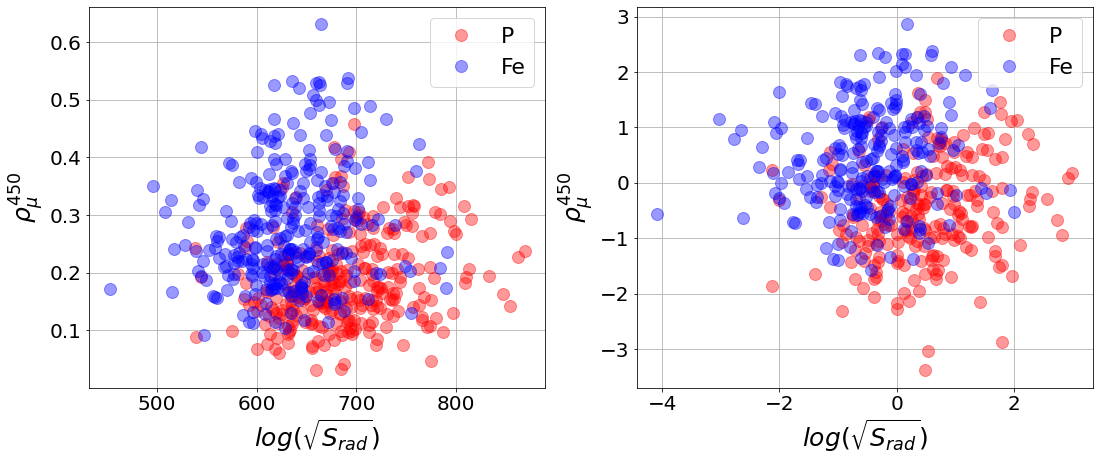

In [33]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(dp["GeoCeXmax"], dp['Mu_LogSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(df["GeoCeXmax"], df['Mu_LogSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==0, 0], XX[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [34]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(dp["GeoCeXmax"], dp['Mu_LogSrad'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(df["GeoCeXmax"], df['Mu_LogSrad'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(500, 1100, 25)
    plt.hist(dp["GeoCeXmax"], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df["GeoCeXmax"], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 12E-4, 20)
    plt.hist(dp['Mu_LogSrad'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['Mu_LogSrad'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

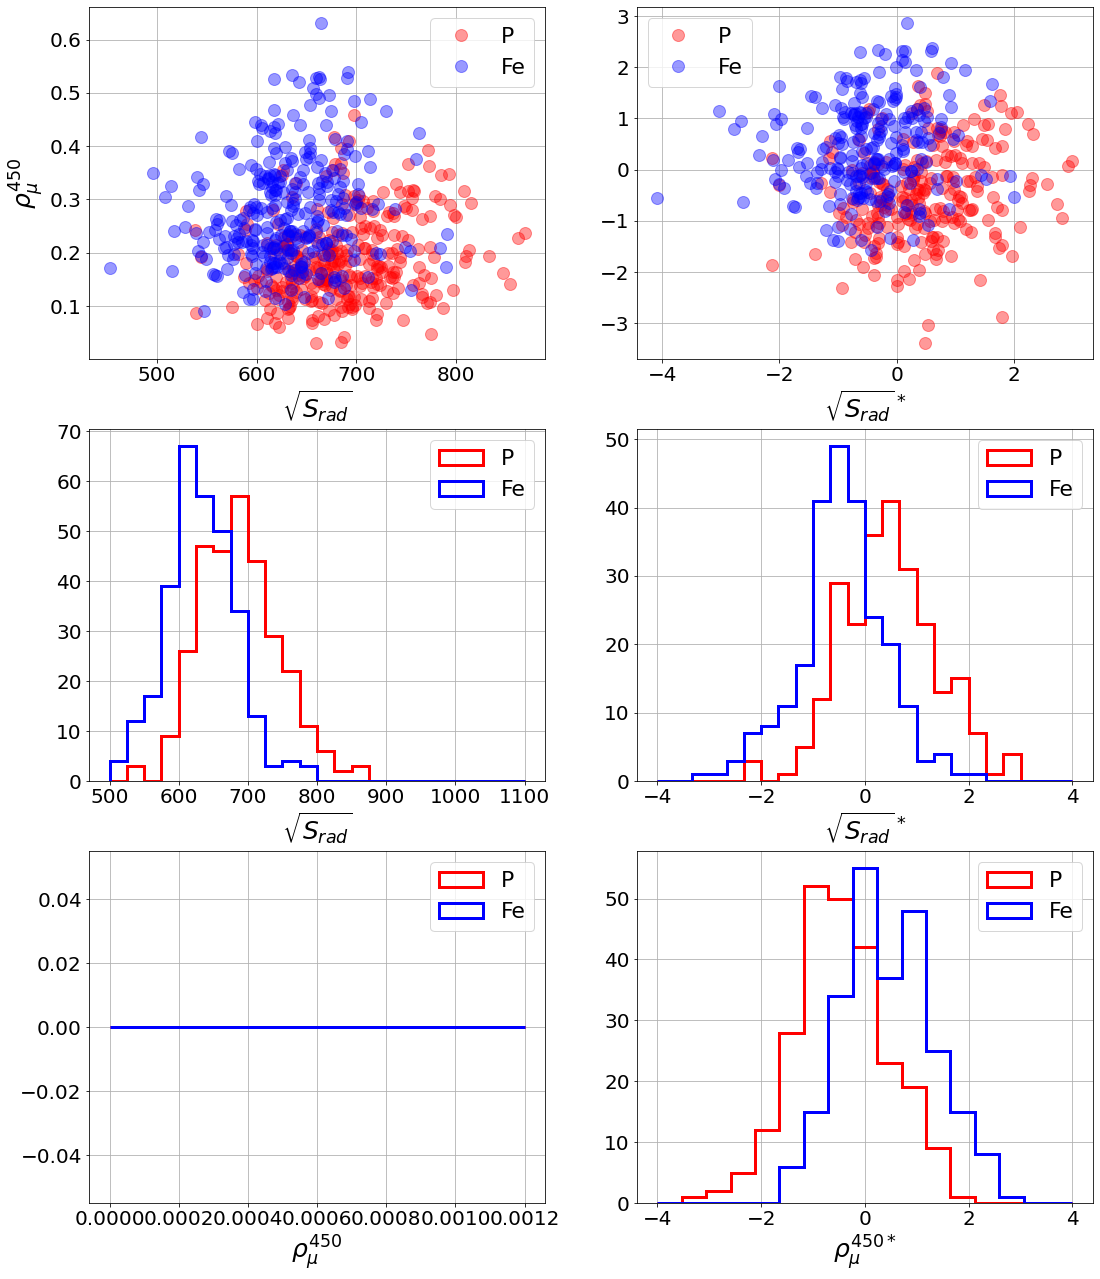

In [35]:
escala(PowerTransformer(method='box-cox'))


In [36]:
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [808]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [809]:
model_Log_1 = rnd_search_cv.best_estimator_
model_Log_1

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.632928856976167, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [810]:
print(accuracy(X_train, y_train, model_Log_1))
print(crossAccuracy(X_train, y_train, model_Log_1))

0.9036885245901639
Accuracy:  0.9036989795918368 0.04853768386221872
presicion:  0.8911557041991826 0.050239009082991795
recall:  0.922 0.056380650739218836
F1_score:  0.9055943738332811 0.04662128858099613
None


In [811]:
mconfusion(X_train, y_train, model_Log_1)

Matriz de confusión, 

[[216  28]
 [ 19 225]]
precisión:  0.8893280632411067
exhaustividad:  0.9221311475409836


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_1.predict(X_train)))

NameError: name 'model_Log_1' is not defined

In [42]:
ypred = cross_val_predict(model_Log_1, X_train, y_train, cv=5, method="decision_function")

In [43]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

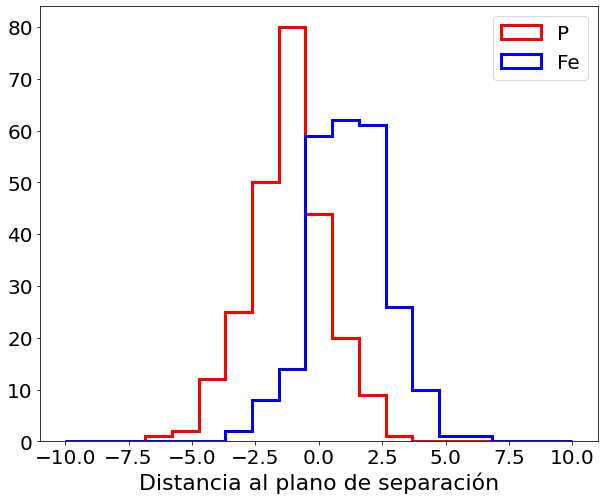

In [44]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [45]:
boostMF(c1_pred, c2_pred)

('1.12', '0.08')

In [46]:
lr=model_Log_1.named_steps['logi_clf']

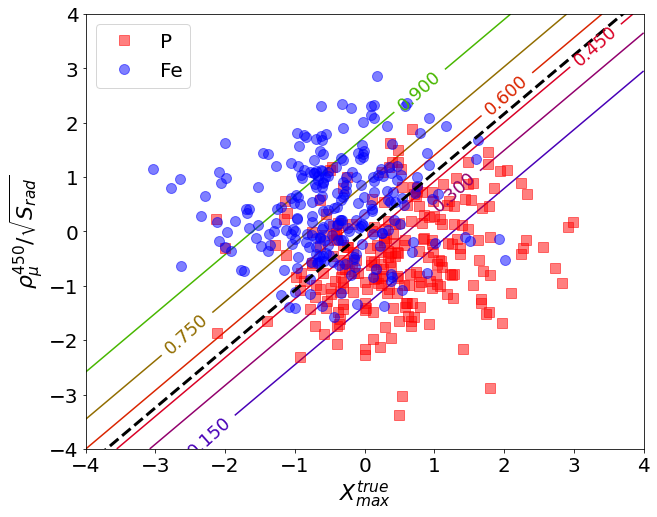

In [47]:
X=X_train
y=y_train

log_reg = model_Log_1.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-4, 4, 500).reshape(-1, 1),
        np.linspace(-4, 4, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-4, 4])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$X^{true}_{max}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=22)
plt.axis([-4, 4, -4, 4])
#save_fig("plano_reglog_plot")
plt.show()

In [38]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [50]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [51]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [52]:
model_Log_2 = rnd_search_cv.best_estimator_
model_Log_2

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.7415711186404937, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [53]:
print(accuracy(X_poly2, y_train, model_Log_2))
print(crossAccuracy(X_poly2, y_train, model_Log_2))

0.8073770491803278
Accuracy:  0.7991496598639455 0.09221530062169257
presicion:  0.8048366250052906 0.08872549589720564
recall:  0.7911666666666667 0.11660248234445478
F1_score:  0.7957616882071926 0.09549302277694437
None


In [54]:
mconfusion(X_poly2, y_train, model_Log_2)

Matriz de confusión, 

[[197  47]
 [ 51 193]]
precisión:  0.8041666666666667
exhaustividad:  0.7909836065573771


In [55]:
print(classification_report(y_train, model_Log_2.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       244
           1       0.81      0.80      0.81       244

    accuracy                           0.81       488
   macro avg       0.81      0.81      0.81       488
weighted avg       0.81      0.81      0.81       488



In [56]:
ypred = cross_val_predict(model_Log_2, X_poly2, y_train, cv=5, method="decision_function")

In [57]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

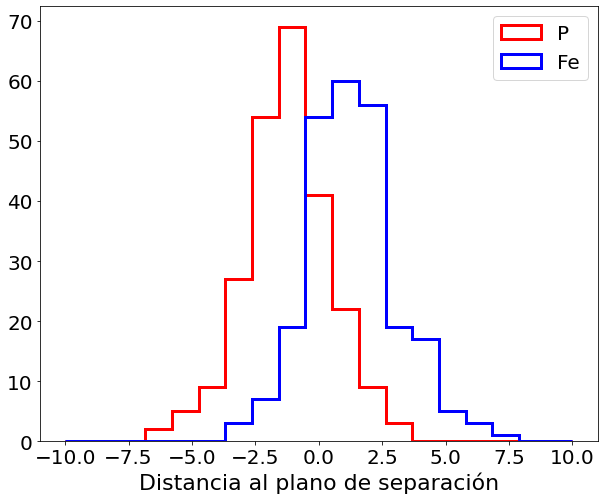

In [58]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [59]:
boostMF(c1_pred, c2_pred)

('1.00', '0.07')

## SVM

In [39]:
from sklearn import svm

In [61]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [62]:
model_svm_1 = rnd_search_cv.best_estimator_
model_svm_1

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=0.029918096463955594, break_ties=False, cache_size=200,
                     class_weight=None, coef0=90.30880842881987,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.01987385314902857, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [63]:
print(accuracy(X_train, y_train, model_svm_1))
print(crossAccuracy(X_train, y_train, model_svm_1))

0.8094262295081968
Accuracy:  0.8135204081632652 0.0872948183685008
presicion:  0.8243052438704612 0.08644190853435738
recall:  0.7991666666666667 0.11555722488110479
F1_score:  0.8087491948604674 0.09154495427450159
None


In [64]:
mconfusion(X_train, y_train, model_svm_1)

Matriz de confusión, 

[[202  42]
 [ 49 195]]
precisión:  0.8227848101265823
exhaustividad:  0.7991803278688525


In [65]:
print(classification_report(y_train, model_svm_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       244
           1       0.82      0.80      0.81       244

    accuracy                           0.81       488
   macro avg       0.81      0.81      0.81       488
weighted avg       0.81      0.81      0.81       488



In [66]:
ypred = cross_val_predict(model_svm_1, X_train, y_train, cv=5, method="decision_function")

In [67]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

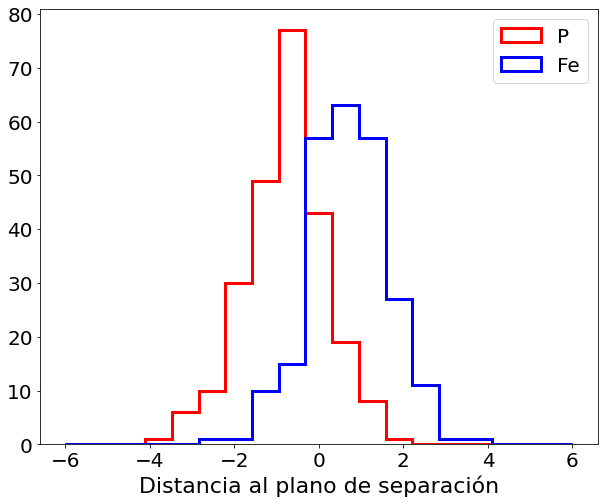

In [68]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [69]:
boostMF(c1_pred, c2_pred)

('1.11', '0.08')

In [70]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [71]:
model_svm_1p = rnd_search_cv.best_estimator_
model_svm_1p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.0676349615967204, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [72]:
print(accuracy(X_train, y_train, model_svm_1p))
print(crossAccuracy(X_train, y_train, model_svm_1p))

0.8012295081967213
Accuracy:  0.8053996598639456 0.0885742731976034
presicion:  0.8081148361026367 0.09435545793298455
recall:  0.812 0.12972577915656464
F1_score:  0.8042887144671799 0.09066429023027894
None


In [73]:
mconfusion(X_train, y_train, model_svm_1p)

Matriz de confusión, 

[[195  49]
 [ 46 198]]
precisión:  0.8016194331983806
exhaustividad:  0.8114754098360656


In [74]:
print(classification_report(y_train, model_svm_1p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       244
           1       0.77      0.85      0.81       244

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488



In [75]:
ypred = cross_val_predict(model_svm_1p, X_train, y_train, cv=5, method="decision_function")

In [76]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

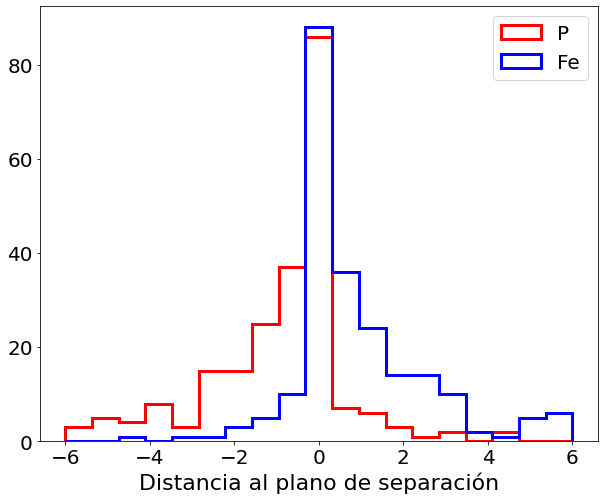

In [77]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [78]:
boostMF(c1_pred, c2_pred)

('0.68', '0.05')

In [79]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [80]:
model_svm_2 = rnd_search_cv.best_estimator_
model_svm_2

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=44.903985568893425, break_ties=False, cache_size=200,
                     class_weight=None, coef0=50.0649808929273,
                     decision_function_shape='ovr', degree=3,
                     gamma=5.1064406962156016e-05, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [81]:
print(accuracy(X_train, y_train, model_svm_2))
print(crossAccuracy(X_train, y_train, model_svm_2))

0.8155737704918032
Accuracy:  0.8157312925170068 0.07981433121765653
presicion:  0.8160114080766254 0.0746234890094474
recall:  0.8158333333333333 0.11014195385955344
F1_score:  0.8136965607937668 0.08375543969973363
None


In [82]:
mconfusion(X_train, y_train, model_svm_2)

Matriz de confusión, 

[[199  45]
 [ 45 199]]
precisión:  0.8155737704918032
exhaustividad:  0.8155737704918032


In [83]:
print(classification_report(y_train, model_svm_2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       244
           1       0.82      0.82      0.82       244

    accuracy                           0.82       488
   macro avg       0.82      0.82      0.82       488
weighted avg       0.82      0.82      0.82       488



In [84]:
ypred = cross_val_predict(model_svm_2, X_train, y_train, cv=5, method="decision_function")

In [85]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

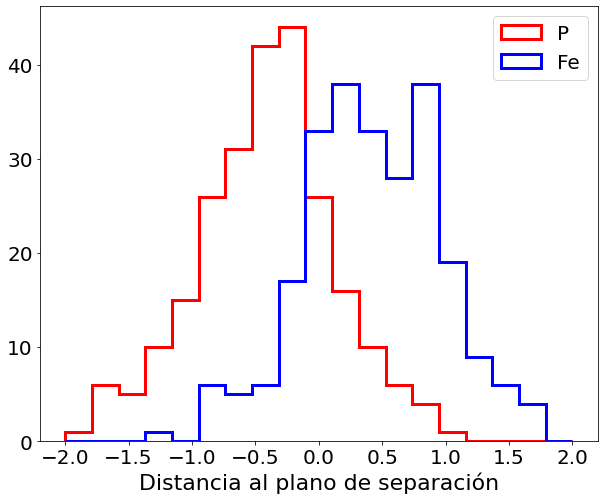

In [86]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-2, 2, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [87]:
boostMF(c1_pred, c2_pred)

('1.12', '0.08')

In [88]:
svcP=model_svm_2.named_steps['svm_clf']

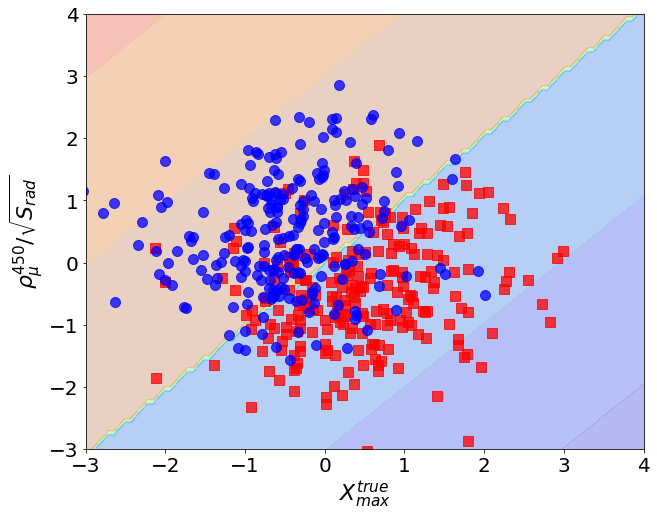

In [89]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model_svm_2.predict(X).reshape(x0.shape)
    y_decision = model_svm_2.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_2,[-3, 4, -3, 7])
plot_dataset(XX, yy,[-3, 4, -3, 4])
plt.xlabel(r"$X^{true}_{max}$")
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$")

plt.show()

## Incluyendo la energía

In [40]:
#Features

df_train_2 = df_train[["MC energy", "Mu_LogSrad_Xmax", "target"]]
df_test_2 = df_test[["MC energy", "Mu_LogSrad_Xmax", "target"]]

In [41]:
print(df_train_2.shape, df_test_.shape)

(488, 3) (122, 64)


In [42]:
df_train_2.head()

,MC energy,Mu_LogSrad_Xmax,target
246,3.824250e+17,0.000453,1
76,7.590210e+17,0.000496,1
171,6.116010e+17,0.000524,1
191,3.842740e+17,0.000343,1
75,9.452550e+17,0.000596,1


In [43]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target             1.000000
Mu_LogSrad_Xmax    0.523241
MC energy         -0.005095
Name: target, dtype: float64

In [44]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [45]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [46]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [47]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [48]:
X_train.head()

,MC energy,Mu_LogSrad_Xmax
0,-0.324464,0.690024
1,1.092195,0.911470
2,0.651643,1.051936
3,-0.314309,0.040163
4,1.534527,1.388400


In [49]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [50]:
#print(XX)

In [51]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(0, 12E3, 25)
    plt.hist(np.sqrt(dp["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(np.sqrt(df["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

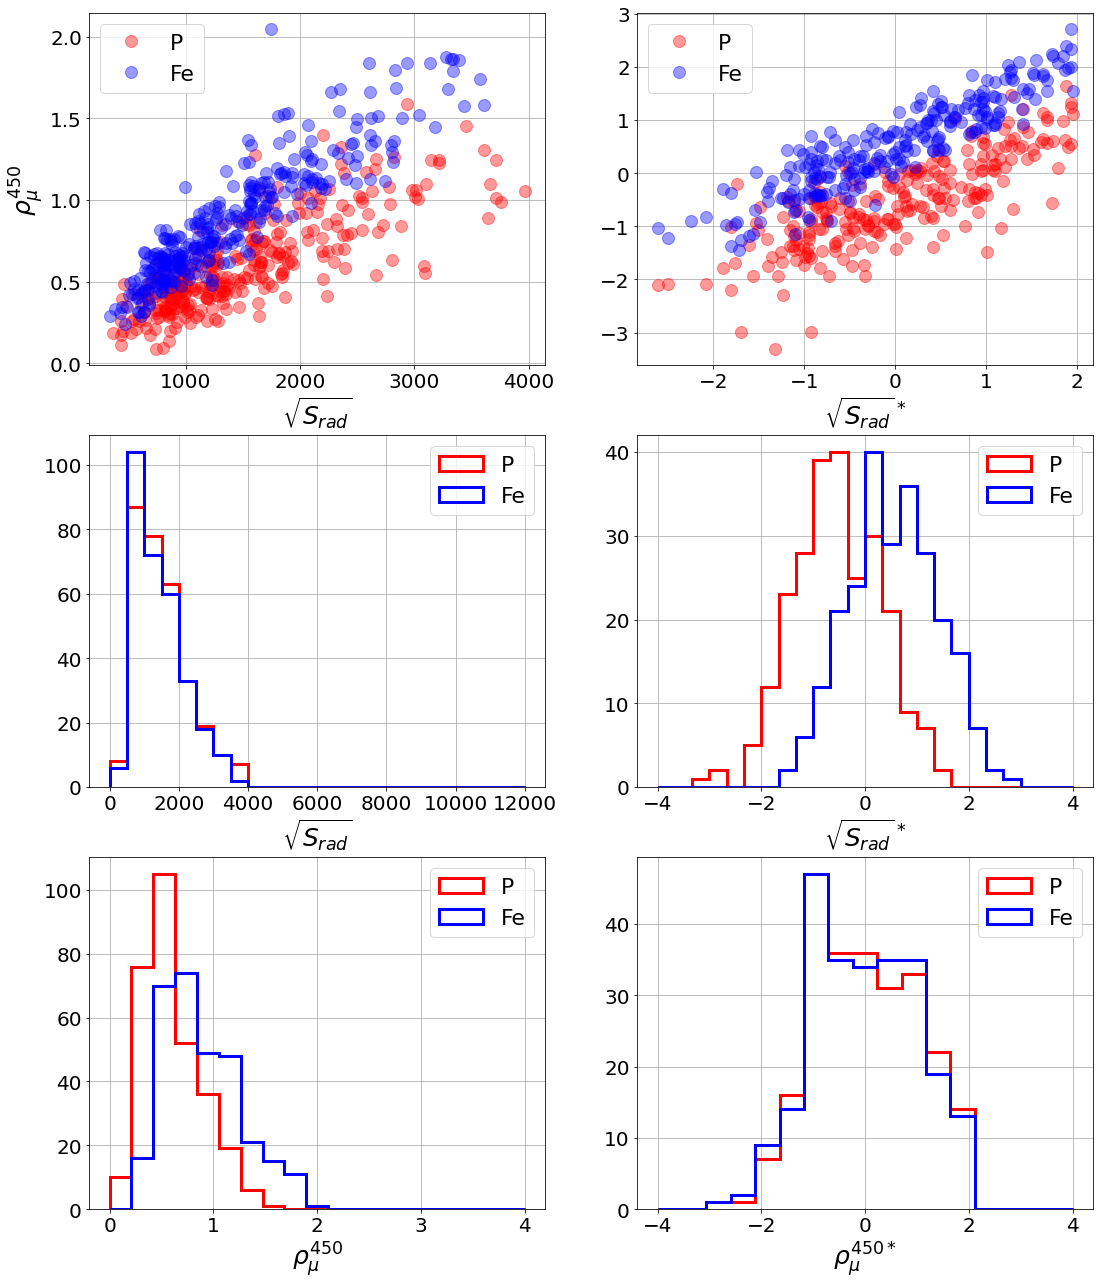

In [52]:
escala(PowerTransformer(method='box-cox'))

In [77]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [78]:
model_Log_3 = rnd_search_cv.best_estimator_
model_Log_3

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.7177887402568305, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [79]:
print(accuracy(X_train, y_train, model_Log_3))
print(crossAccuracy(X_train, y_train, model_Log_3))

0.9036885245901639
Accuracy:  0.9036989795918368 0.04853768386221872
presicion:  0.8911557041991826 0.050239009082991795
recall:  0.922 0.056380650739218836
F1_score:  0.9055943738332811 0.04662128858099613
None


In [80]:
auc_cv(X_train, y_train, model_Log_3)

0.9573541666666665 0.033924452679200766


In [81]:
print(crossAccuracy(X_test, y_test, model_Log_3))

Accuracy:  0.8698717948717949 0.09751388579284213
presicion:  0.8488095238095239 0.09464847243000456
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8735897435897435 0.09612512391529986
None


In [82]:
auc_cv(X_test, y_test, model_Log_3)

0.9134920634920635 0.09273835842957674


In [83]:
mconfusion(X_train, y_train, model_Log_3)

Matriz de confusión, 

[[216  28]
 [ 19 225]]
precisión:  0.8893280632411067
exhaustividad:  0.9221311475409836


In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.91       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [85]:
ypred = cross_val_predict(model_Log_3, X_train, y_train, cv=5, method="decision_function")

In [86]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

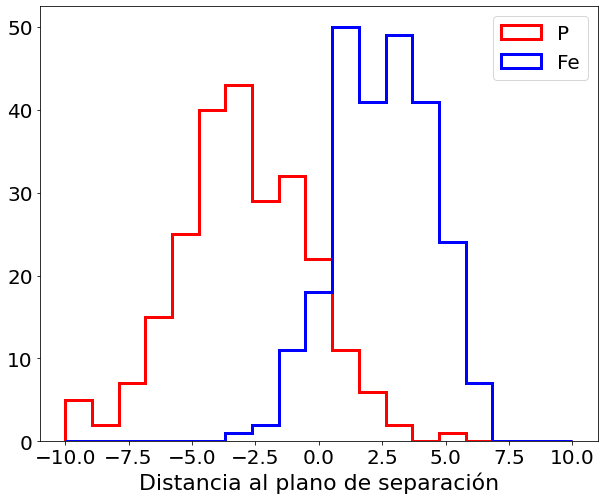

In [87]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [88]:
boostMF(c1_pred, c2_pred)

('1.68', '0.09')

In [89]:
log_reg=model_Log_3.named_steps['logi_clf']

In [90]:
print(log_reg.coef_[0][0])

-3.8321753216718775


Saving figure plano_reglog_plot_best_obs_5


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


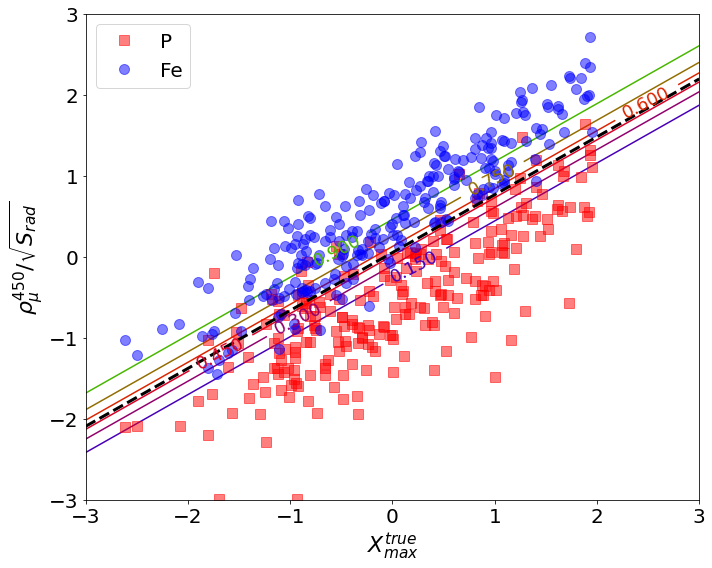

In [91]:
x0, x1 = np.meshgrid(
        np.linspace(-3, 3, 500).reshape(-1, 1),
        np.linspace(-3, 3, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$X^{true}_{max}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$", fontsize=22)
plt.axis([-3, 3, -3, 3])
#save_fig("plano_reglog_plot_best_obs_5")
plt.show()

In [92]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [843]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [117]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [118]:
model_Log_4 = rnd_search_cv.best_estimator_
model_Log_4

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.5613918832108932, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [119]:
print(accuracy(X_poly2, y_train, model_Log_4))
print(crossAccuracy(X_poly2, y_train, model_Log_4))

0.9057377049180327
Accuracy:  0.8975340136054422 0.04947671765386774
presicion:  0.8841883503802543 0.051880330172312715
recall:  0.9178333333333333 0.06382724078844916
F1_score:  0.8995371847185947 0.04827171178346215
None


In [120]:
mconfusion(X_poly2, y_train, model_Log_4)

Matriz de confusión, 

[[214  30]
 [ 20 224]]
precisión:  0.8818897637795275
exhaustividad:  0.9180327868852459


In [121]:
print(classification_report(y_train, model_Log_4.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [122]:
ypred = cross_val_predict(model_Log_4, X_poly2, y_train, cv=5, method="decision_function")

In [123]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

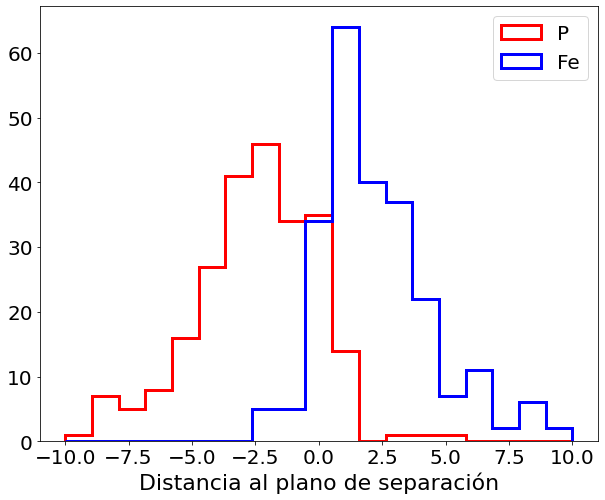

In [124]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [125]:
boostMF(c1_pred, c2_pred)

('1.14', '0.12')

## SVM

In [55]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [56]:
model_svm_3 = rnd_search_cv.best_estimator_
model_svm_3

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.2856846473832646, break_ties=False, cache_size=200,
                     class_weight=None, coef0=56.92708907681995,
                     decision_function_shape='ovr', degree=3,
                     gamma=5.018881728556448e-06, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [57]:
print(accuracy(X_train, y_train, model_svm_3))
print(crossAccuracy(X_train, y_train, model_svm_3))

0.8995901639344263
Accuracy:  0.9016581632653061 0.045646734520313675
presicion:  0.8847826883261666 0.04992625099066315
recall:  0.9259999999999999 0.051640853766933184
F1_score:  0.9041875484035445 0.04377681161619095
None


In [58]:
auc_cv(X_train, y_train, model_svm_3)

0.9573472222222221 0.03391291270516509


In [59]:
print(crossAccuracy(X_test, y_test, model_svm_3))

Accuracy:  0.8467948717948717 0.12408276224728598
presicion:  0.8388095238095238 0.10929608831351156
recall:  0.869047619047619 0.16296919008235813
F1_score:  0.846905251611134 0.12641691761930804
None


In [60]:
auc_cv(X_test, y_test, model_svm_3)

0.9107142857142858 0.09466178140972409


In [61]:
mconfusion(X_train, y_train, model_svm_3)

Matriz de confusión, 

[[214  30]
 [ 18 226]]
precisión:  0.8828125
exhaustividad:  0.9262295081967213


In [62]:
print(classification_report(y_train, model_svm_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [63]:
ypred = cross_val_predict(model_svm_3, X_train, y_train, cv=5, method="decision_function")

In [64]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

Saving figure obs_5_hist_best


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


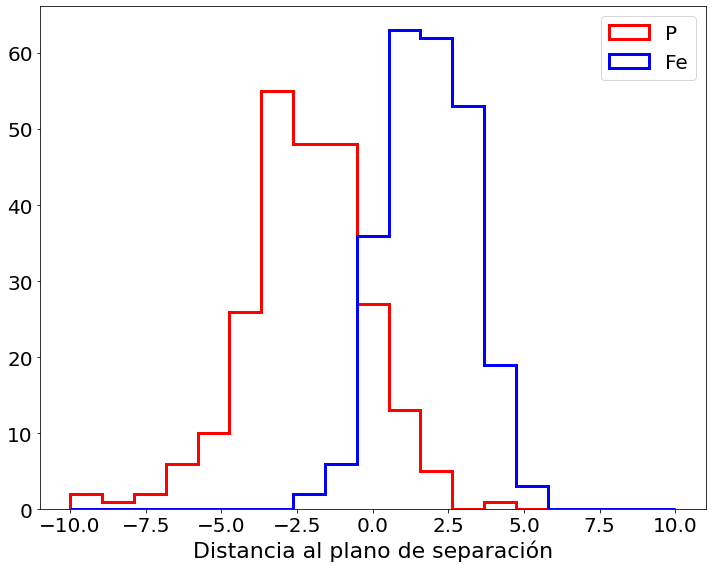

In [74]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
#save_fig("obs_5_hist_best")
plt.show()

In [66]:
boostMF(c1_pred, c2_pred)

('1.69', '0.09')

Saving figure plano_SVM_plot_best_ obs_4


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


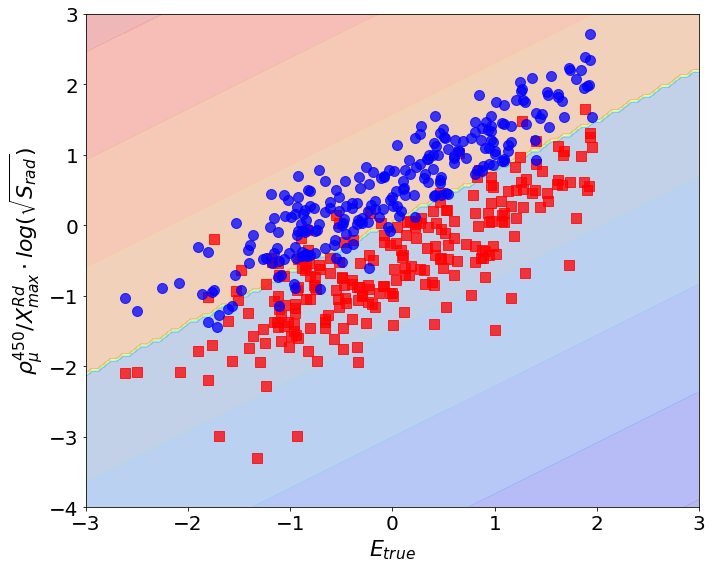

In [75]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)
    
plt.figure(figsize=(10, 8))
plot_predictions(model_svm_3,[-3, 3, -4, 3])
plot_dataset(XX, yy,[-3, 3, -4, 3])
plt.xlabel(r"$E_{true}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / X^{Rd}_{max} \cdot log(\sqrt{S_{rad}})$", fontsize=22)
#save_fig("plano_SVM_plot_best_ obs_4")
plt.show()

In [135]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [136]:
model_svm_3p = rnd_search_cv.best_estimator_
model_svm_3p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=27.04469506434105, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [137]:
print(accuracy(X_train, y_train, model_svm_3p))
print(crossAccuracy(X_train, y_train, model_svm_3p))

0.8831967213114754
Accuracy:  0.8853316326530611 0.04937249771939716
presicion:  0.8384262288539988 0.05936976836940632
recall:  0.9628333333333334 0.047299577165129066
F1_score:  0.8946661761119952 0.04172905257448947
None


In [138]:
mconfusion(X_train, y_train, model_svm_3p)

Matriz de confusión, 

[[197  47]
 [  9 235]]
precisión:  0.8333333333333334
exhaustividad:  0.9631147540983607


In [139]:
print(classification_report(y_train, model_svm_3p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       244
           1       0.83      0.97      0.89       244

    accuracy                           0.88       488
   macro avg       0.89      0.88      0.88       488
weighted avg       0.89      0.88      0.88       488



In [140]:
ypred = cross_val_predict(model_svm_3p, X_train, y_train, cv=5, method="decision_function")

In [141]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

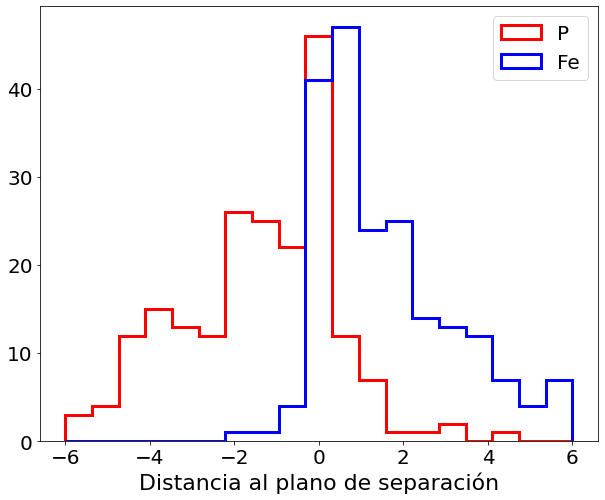

In [142]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [143]:
boostMF(c1_pred, c2_pred)

('0.74', '0.09')

In [884]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [885]:
model_svm_4 = rnd_search_cv.best_estimator_
model_svm_4

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=3.381463909697362, break_ties=False, cache_size=200,
                     class_weight=None, coef0=53.0420196184619,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.017180395448052194, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [886]:
print(accuracy(X_train, y_train, model_svm_4))
print(crossAccuracy(X_train, y_train, model_svm_4))

0.9016393442622951
Accuracy:  0.8995748299319727 0.041472196460671414
presicion:  0.872186659417544 0.042039098834118854
recall:  0.9380000000000001 0.053467539477497716
F1_score:  0.9031182057371769 0.04015437117239054
None


In [887]:
auc_cv(X_train, y_train, model_svm_4)

0.9585555555555555 0.032735624966927196


In [888]:
print(crossAccuracy(X_test, y_test, model_svm_4))

Accuracy:  0.8698717948717949 0.09751388579284213
presicion:  0.8488095238095239 0.09464847243000456
recall:  0.9023809523809524 0.10934250003052413
F1_score:  0.8735897435897435 0.09612512391529986
None


In [889]:
auc_cv(X_test, y_test, model_svm_4)

0.9166666666666667 0.08295454349351936


In [890]:
mconfusion(X_train, y_train, model_svm_4)

Matriz de confusión, 

[[210  34]
 [ 15 229]]
precisión:  0.870722433460076
exhaustividad:  0.9385245901639344


In [891]:
print(classification_report(y_train, model_svm_4.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       244
           1       0.87      0.94      0.91       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [892]:
ypred = cross_val_predict(model_svm_4, X_train, y_train, cv=5, method="decision_function")

In [893]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

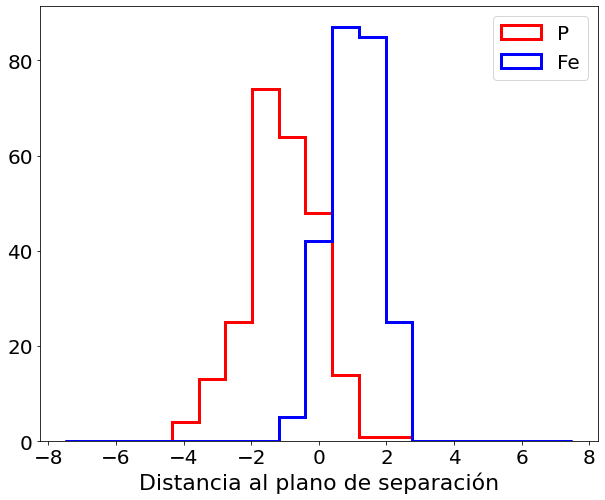

In [894]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-7.5, 7.5, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [895]:
boostMF(c1_pred, c2_pred)

('1.72', '0.09')

In [896]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [897]:
svcP=model_svm_4.named_steps['svm_clf']

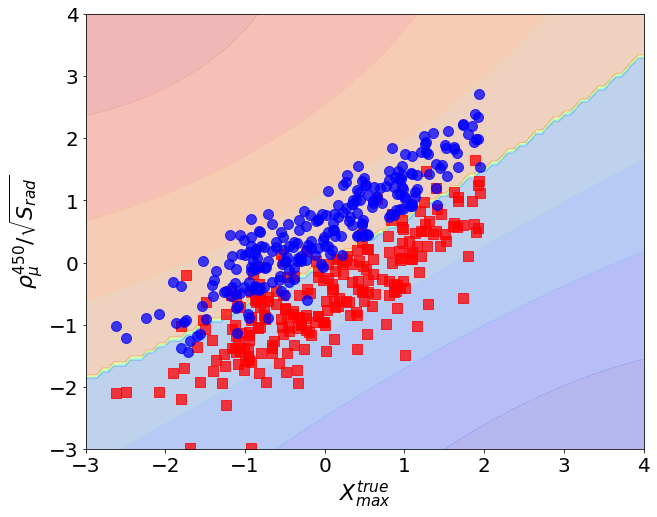

In [898]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model_svm_4.predict(X).reshape(x0.shape)
    y_decision = model_svm_4.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_4,[-3, 4, -3, 7])
plot_dataset(XX, y,[-3, 4, -3, 4])
plt.xlabel(r"$X^{true}_{max}$")
plt.ylabel(r"$\rho^{450}_{\mu} / \sqrt{S_{rad}}$")

plt.show()

In [868]:
X=X_train.select_dtypes(include=float).to_numpy()
y=y_train

In [797]:
svcP=model_svm_3.named_steps['svm_clf']

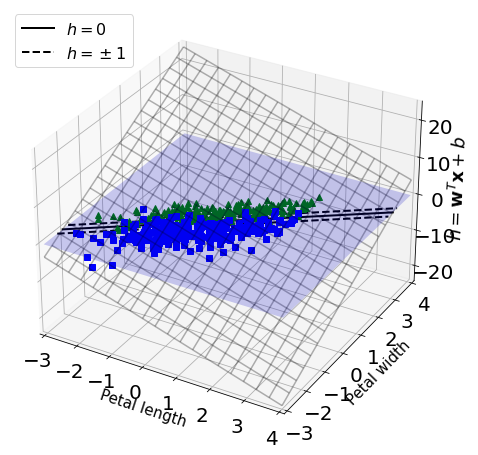

In [799]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[-3, 4], x2_lim=[-3, 4]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    #ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svcP.coef_[0], b=svcP.intercept_[0])

#save_fig("iris_3D_plot")
plt.show()



## Variables base + Energía

In [537]:
#Features

df_train_2 = df_train[["GeoCeXmax", "Mu_LogSrad", "MC energy", "target"]]
df_test_2 = df_test[["GeoCeXmax", "Mu_LogSrad", "MC energy", "target"]]

In [538]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 64)


In [539]:
df_train_2.head()

,GeoCeXmax,Mu_LogSrad,MC energy,target
246,610.506,0.276681,3.824250e+17,1
76,670.556,0.332348,7.590210e+17,1
171,669.154,0.350593,6.116010e+17,1
191,571.015,0.196055,3.842740e+17,1
75,599.145,0.357259,9.452550e+17,1


In [540]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target        1.000000
Mu_LogSrad    0.441245
MC energy    -0.005095
GeoCeXmax    -0.461443
Name: target, dtype: float64

In [541]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [542]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [543]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [544]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [545]:
X_train.head()

,GeoCeXmax,Mu_LogSrad,MC energy
0,-0.751797,0.546207,-0.324464
1,0.260940,1.012950,1.092195
2,0.238489,1.153904,0.651643
3,-1.481640,-0.264631,-0.314309
4,-0.956135,1.204120,1.534527


In [546]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [588]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [589]:
model_svm_44 = rnd_search_cv.best_estimator_
model_svm_44

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=9.865421838995994, break_ties=False, cache_size=200,
                     class_weight=None, coef0=19.518917096535315,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.015042822485395761, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [590]:
print(accuracy(X_train, y_train, model_svm_44))
print(crossAccuracy(X_train, y_train, model_svm_44))

0.9098360655737705
Accuracy:  0.9016581632653061 0.04587663841505021
presicion:  0.8809136974136974 0.042585902596662624
recall:  0.9299999999999999 0.061900457725825156
F1_score:  0.9039667666018889 0.045844162650376635
None


In [591]:
mconfusion(X_train, y_train, model_svm_44)

Matriz de confusión, 

[[213  31]
 [ 17 227]]
precisión:  0.8798449612403101
exhaustividad:  0.930327868852459


In [592]:
print(classification_report(y_train, model_svm_44.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       244
           1       0.89      0.94      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [593]:
ypred = cross_val_predict(model_svm_44, X_train, y_train, cv=5, method="decision_function")

In [594]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

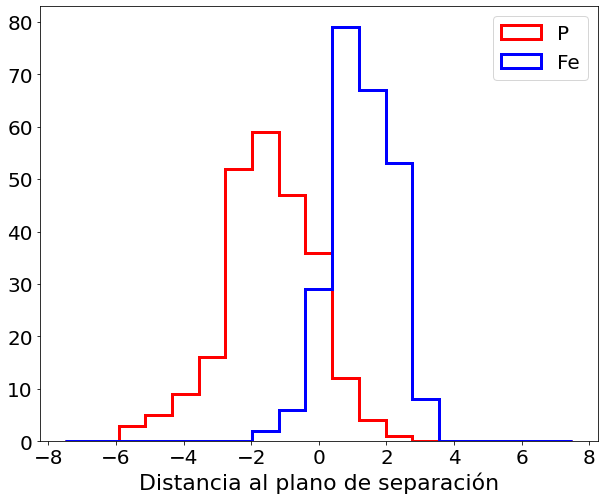

In [595]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-7.5, 7.5, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [596]:
boostMF(c1_pred, c2_pred)

('1.70', '0.09')

In [578]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 10)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [579]:
model_Log_55 = rnd_search_cv.best_estimator_
model_Log_55

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.6469510637919517, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [580]:
print(accuracy(X_train, y_train, model_Log_55))
print(crossAccuracy(X_train, y_train, model_Log_55))

0.9057377049180327
Accuracy:  0.9077806122448979 0.04787892597698407
presicion:  0.8984985135637309 0.05070275864088575
recall:  0.922 0.056380650739218836
F1_score:  0.9092599975295681 0.04582885322062142
None


In [581]:
mconfusion(X_train, y_train, model_Log_55)

Matriz de confusión, 

[[218  26]
 [ 19 225]]
precisión:  0.896414342629482
exhaustividad:  0.9221311475409836


In [582]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_55.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [583]:
ypred = cross_val_predict(model_Log_55, X_train, y_train, cv=5, method="decision_function")

In [584]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

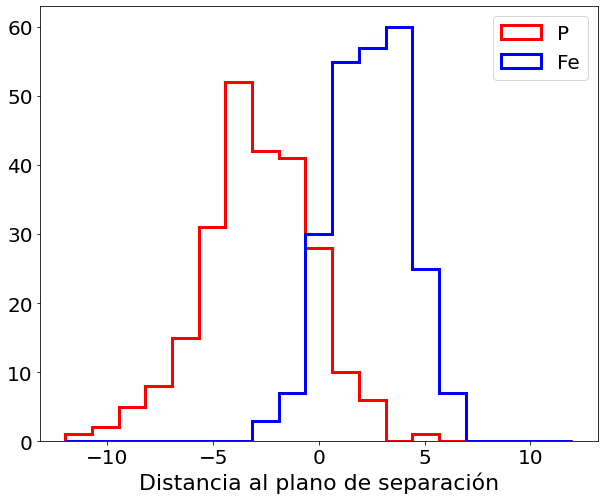

In [587]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-12, 12, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [586]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

# Variables individuales

In [666]:
#Features

df_train_2 = df_train[["GeoCeXmax", "LogSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["GeoCeXmax", "LogSrad", "N_mu_ref", "target"]]

In [667]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 64)


In [668]:
df_train_2.head()

,GeoCeXmax,LogSrad,N_mu_ref,target
246,610.506,3.074320,0.850606,1
76,670.556,3.352450,1.114180,1
171,669.154,3.271228,1.146870,1
191,571.015,3.122918,0.612265,1
75,599.145,3.448698,1.232080,1


In [669]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
LogSrad     -0.060095
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [670]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [671]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [672]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [673]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [674]:
X_train.head()

,GeoCeXmax,LogSrad,N_mu_ref
0,-0.751797,-0.187830,0.462230
1,0.260940,1.099993,1.066291
2,0.238489,0.723505,1.133262
3,-1.481640,0.036905,-0.224563
4,-0.956135,1.546554,1.301173


In [675]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [676]:
print(XX)

[[-0.75179729 -0.18782976  0.46222978]
 [ 0.26094042  1.09999301  1.06629128]
 [ 0.23848901  0.72350483  1.13326226]
 ...
 [-0.75318541  0.69829233 -0.4185472 ]
 [ 2.23809473  0.98608548  0.93574021]
 [ 1.55414211  1.10537637  0.96498853]]


In [677]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(np.sqrt(dp["GeoCe Erad"]), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(np.sqrt(df["GeoCe Erad"]), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[y==0, 0], Xss[y==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[y==1, 0], Xss[y==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(0, 12E3, 25)
    plt.hist(np.sqrt(dp["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(np.sqrt(df["GeoCe Erad"]), bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\sqrt{S_{rad}}^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

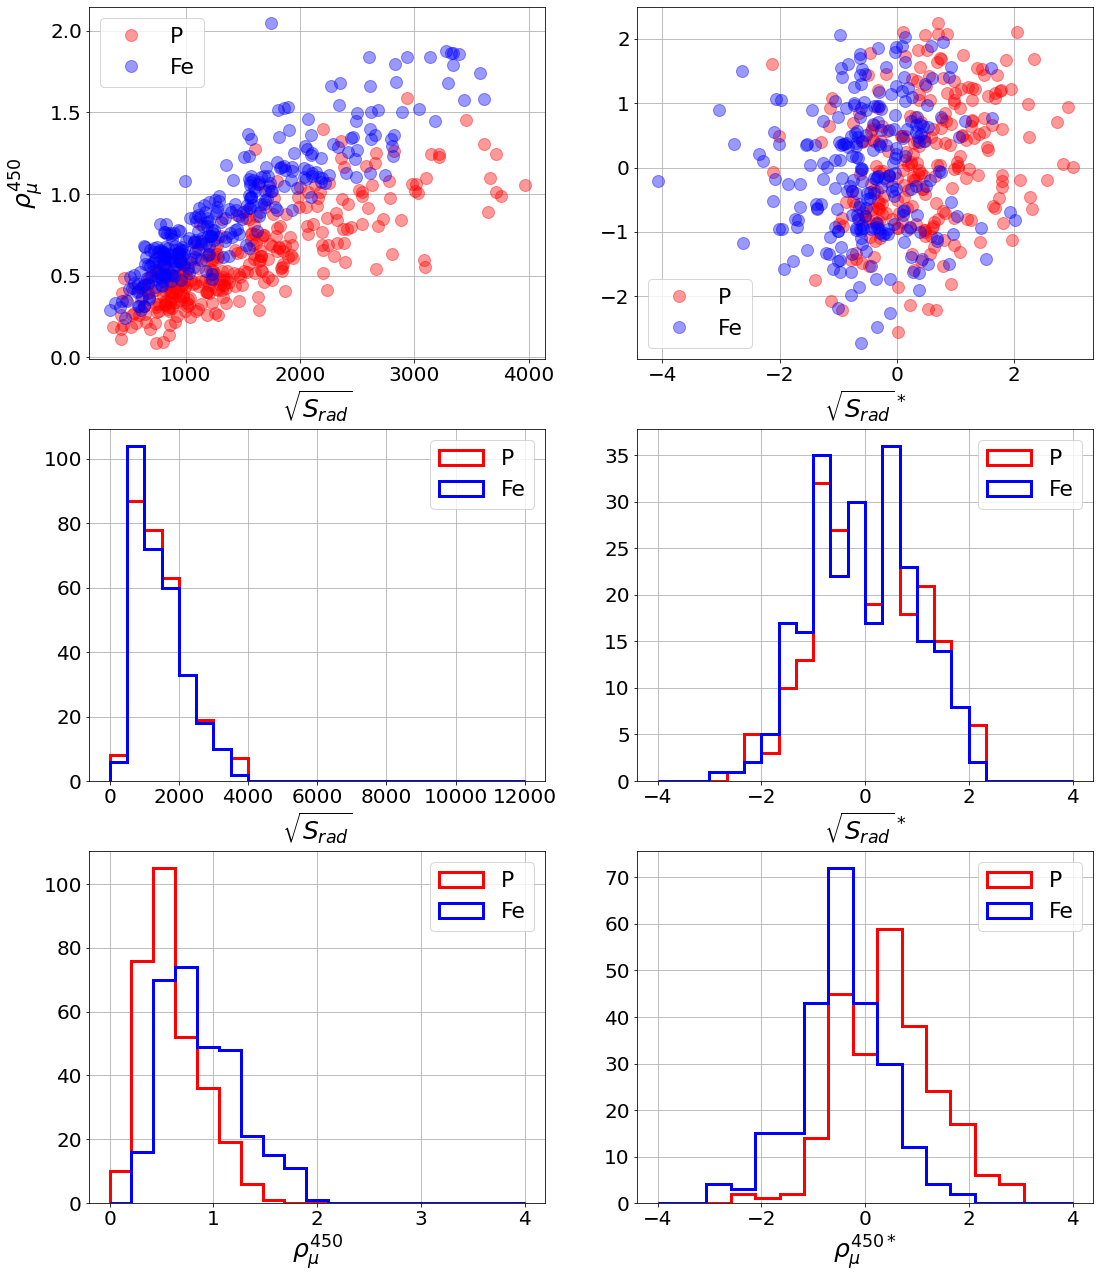

In [678]:
escala(PowerTransformer(method='box-cox'))

In [679]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [680]:
model_Log_5 = rnd_search_cv.best_estimator_
model_Log_5

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.0118614710829856, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [681]:
print(accuracy(X_train, y_train, model_Log_5))
print(crossAccuracy(X_train, y_train, model_Log_5))

0.889344262295082
Accuracy:  0.8748724489795918 0.05508145099587019
presicion:  0.8629679369537382 0.05308892999141198
recall:  0.8969999999999999 0.0971848182016558
F1_score:  0.87588786433011 0.06073477988908949
None


In [682]:
mconfusion(X_train, y_train, model_Log_5)

Matriz de confusión, 

[[208  36]
 [ 25 219]]
precisión:  0.8588235294117647
exhaustividad:  0.8975409836065574


In [683]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       244
           1       0.87      0.91      0.89       244

    accuracy                           0.89       488
   macro avg       0.89      0.89      0.89       488
weighted avg       0.89      0.89      0.89       488



In [684]:
ypred = cross_val_predict(model_Log_5, X_train, y_train, cv=5, method="decision_function")

In [685]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

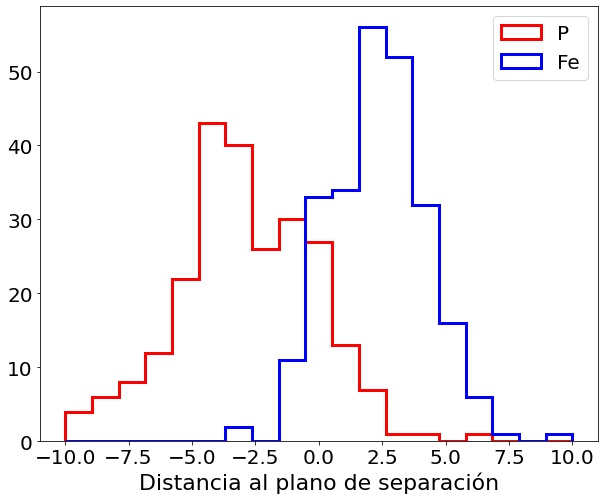

In [686]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [687]:
boostMF(c1_pred, c2_pred)

('1.57', '0.09')

In [178]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 19)

In [688]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 19)

In [179]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [180]:
model_Log_6 = rnd_search_cv.best_estimator_
model_Log_6

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.4160533179899283, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [181]:
print(accuracy(X_poly2, y_train, model_Log_6))
print(crossAccuracy(X_poly2, y_train, model_Log_6))

0.8954918032786885
Accuracy:  0.8749149659863946 0.060128368163946885
presicion:  0.8584974222155886 0.06490364109017502
recall:  0.9053333333333333 0.0835457293276496
F1_score:  0.8784190652127458 0.060550150812722935
None


In [182]:
mconfusion(X_poly2, y_train, model_Log_6)

Matriz de confusión, 

[[206  38]
 [ 23 221]]
precisión:  0.8532818532818532
exhaustividad:  0.9057377049180327


In [183]:
print(classification_report(y_train, model_Log_6.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [184]:
ypred = cross_val_predict(model_Log_6, X_poly2, y_train, cv=5, method="decision_function")

In [185]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

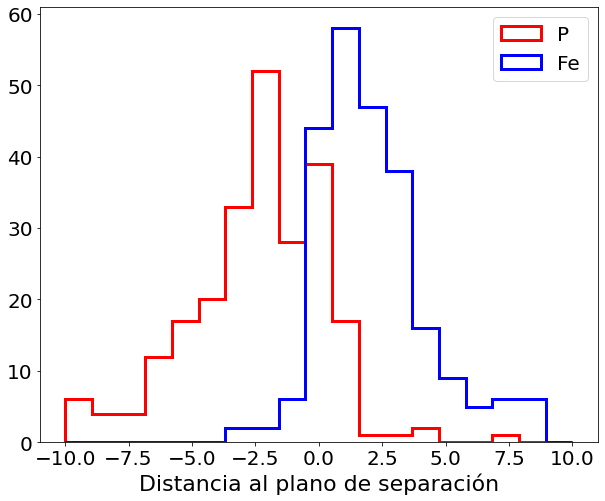

In [186]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [187]:
boostMF(c1_pred, c2_pred)

('1.13', '0.09')

## SVM

In [689]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [690]:
model_svm_5 = rnd_search_cv.best_estimator_
model_svm_5

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=0.42421730385111656, break_ties=False, cache_size=200,
                     class_weight=None, coef0=71.41886905765654,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.027886889588729157, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [691]:
print(accuracy(X_train, y_train, model_svm_5))
print(crossAccuracy(X_train, y_train, model_svm_5))

0.8831967213114754
Accuracy:  0.8749149659863946 0.049241155451121454
presicion:  0.8606328575638921 0.05220126338643816
recall:  0.9011666666666664 0.08181975447422353
F1_score:  0.8773630257134301 0.05108246930288846
None


In [692]:
mconfusion(X_train, y_train, model_svm_5)

Matriz de confusión, 

[[207  37]
 [ 24 220]]
precisión:  0.8560311284046692
exhaustividad:  0.9016393442622951


In [693]:
print(classification_report(y_train, model_svm_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       244
           1       0.86      0.91      0.89       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [694]:
ypred = cross_val_predict(model_svm_5, X_train, y_train, cv=5, method="decision_function")

In [695]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

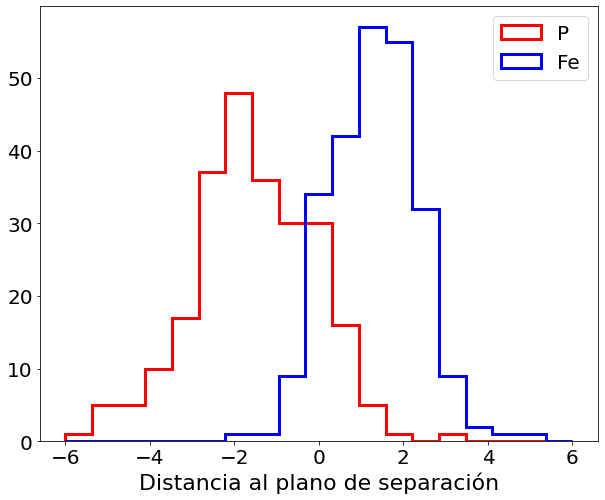

In [696]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [697]:
boostMF(c1_pred, c2_pred)

('1.58', '0.09')

In [197]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [198]:
model_svm_5p = rnd_search_cv.best_estimator_
model_svm_5p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.5318514742038825, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [199]:
print(accuracy(X_train, y_train, model_svm_5p))
print(crossAccuracy(X_train, y_train, model_svm_5p))

0.875
Accuracy:  0.8749574829931973 0.05778699413630353
presicion:  0.8533171617030313 0.06308442126211702
recall:  0.9138333333333334 0.08176541648724925
F1_score:  0.8796818959733581 0.05556824336621926
None


In [200]:
mconfusion(X_train, y_train, model_svm_5p)

Matriz de confusión, 

[[204  40]
 [ 21 223]]
precisión:  0.8479087452471483
exhaustividad:  0.9139344262295082


In [201]:
print(classification_report(y_train, model_svm_5p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       244
           1       0.84      0.93      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [202]:
ypred = cross_val_predict(model_svm_5p, X_train, y_train, cv=5, method="decision_function")

In [203]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

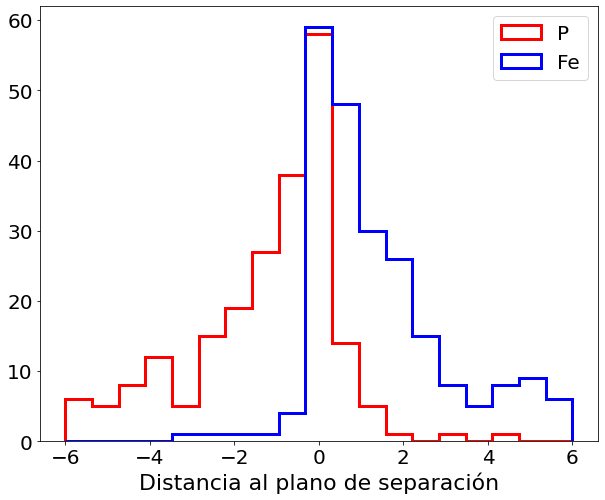

In [204]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [205]:
boostMF(c1_pred, c2_pred)

('0.83', '0.07')

In [707]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [708]:
model_svm_6 = rnd_search_cv.best_estimator_
model_svm_6

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.160756620315538, break_ties=False, cache_size=200,
                     class_weight=None, coef0=9.418398650150172,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.002002708109222297, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [709]:
print(accuracy(X_train, y_train, model_svm_6))
print(crossAccuracy(X_train, y_train, model_svm_6))

0.8729508196721312
Accuracy:  0.8729591836734695 0.06577060761569149
presicion:  0.8489918670091084 0.07549172255231103
recall:  0.9178333333333333 0.07391079458073467
F1_score:  0.8792871827747989 0.059136417430428606
None


In [710]:
mconfusion(X_train, y_train, model_svm_6)

Matriz de confusión, 

[[202  42]
 [ 20 224]]
precisión:  0.8421052631578947
exhaustividad:  0.9180327868852459


In [711]:
print(classification_report(y_train, model_svm_6.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       244
           1       0.84      0.92      0.88       244

    accuracy                           0.87       488
   macro avg       0.88      0.87      0.87       488
weighted avg       0.88      0.87      0.87       488



In [712]:
ypred = cross_val_predict(model_svm_6, X_train, y_train, cv=5, method="decision_function")

In [713]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

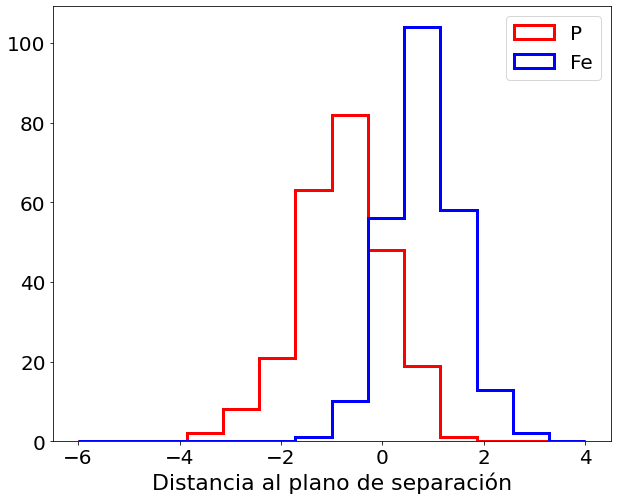

In [714]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 4, 15)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [715]:
boostMF(c1_pred, c2_pred)

('1.51', '0.08')

## Incluyendo la Energía

In [716]:
#Features

df_train_2 = df_train[["GeoCeXmax", "LogSrad", "N_mu_ref", "MC energy", "target"]]
df_test_2 = df_test[["GeoCeXmax", "LogSrad", "N_mu_ref", "MC energy", "target"]]

In [717]:
print(df_train_2.shape, df_test_.shape)

(488, 5) (122, 64)


In [718]:
df_train_2.head()

,GeoCeXmax,LogSrad,N_mu_ref,MC energy,target
246,610.506,3.074320,0.850606,3.824250e+17,1
76,670.556,3.352450,1.114180,7.590210e+17,1
171,669.154,3.271228,1.146870,6.116010e+17,1
191,571.015,3.122918,0.612265,3.842740e+17,1
75,599.145,3.448698,1.232080,9.452550e+17,1


In [719]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC energy   -0.005095
LogSrad     -0.060095
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [720]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 4) (488,) (488, 4) (122,)


In [721]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [722]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [723]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 4) (122, 4) (488,) (122,)


In [724]:
X_train.head()

,GeoCeXmax,LogSrad,N_mu_ref,MC energy
0,-0.751797,-0.187830,0.462230,-0.324464
1,0.260940,1.099993,1.066291,1.092195
2,0.238489,0.723505,1.133262,0.651643
3,-1.481640,0.036905,-0.224563,-0.314309
4,-0.956135,1.546554,1.301173,1.534527


In [725]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [726]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=500, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [727]:
model_Log_7 = rnd_search_cv.best_estimator_
model_Log_7

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=969.0205609289133, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [728]:
print(accuracy(X_train, y_train, model_Log_7))
print(crossAccuracy(X_train, y_train, model_Log_7))

0.9016393442622951
Accuracy:  0.8995748299319729 0.048172275306400676
presicion:  0.8905860443903922 0.0495580546000501
recall:  0.9136666666666666 0.06511442919114695
F1_score:  0.9007710711542074 0.047312861038369944
None


In [729]:
mconfusion(X_train, y_train, model_Log_7)

Matriz de confusión, 

[[216  28]
 [ 21 223]]
precisión:  0.8884462151394422
exhaustividad:  0.9139344262295082


In [730]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [731]:
ypred = cross_val_predict(model_Log_7, X_train, y_train, cv=5, method="decision_function")

In [732]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

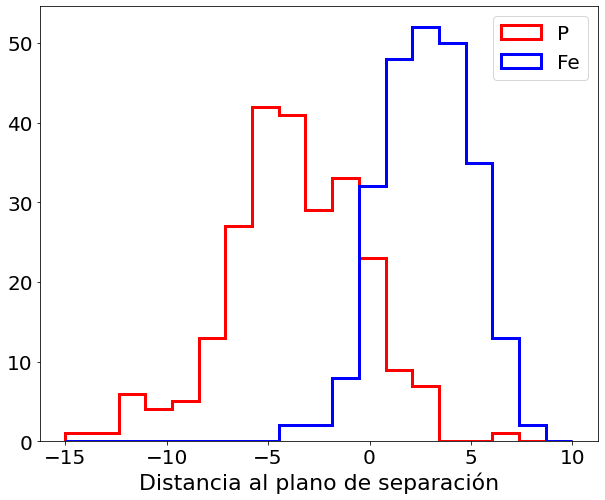

In [734]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-15, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [735]:
boostMF(c1_pred, c2_pred)

('1.64', '0.09')

In [234]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 34)

In [235]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 34)

In [236]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=500, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [237]:
model_Log_8 = rnd_search_cv.best_estimator_
model_Log_8

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.534198413386878, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [238]:
print(accuracy(X_poly2, y_train, model_Log_8))
print(crossAccuracy(X_poly2, y_train, model_Log_8))

0.9098360655737705
Accuracy:  0.8893282312925171 0.043288932208387046
presicion:  0.8686168718810544 0.049017132154323684
recall:  0.9216666666666666 0.057120729842831834
F1_score:  0.8929598212661027 0.040983622504126654
None


In [239]:
mconfusion(X_poly2, y_train, model_Log_8)

Matriz de confusión, 

[[209  35]
 [ 19 225]]
precisión:  0.8653846153846154
exhaustividad:  0.9221311475409836


In [240]:
print(classification_report(y_train, model_Log_8.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       244
           1       0.89      0.93      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [241]:
ypred = cross_val_predict(model_Log_8, X_poly2, y_train, cv=5, method="decision_function")

In [242]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

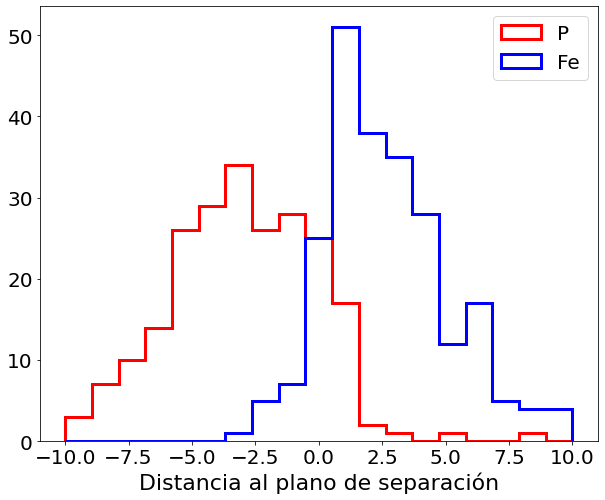

In [243]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [244]:
boostMF(c1_pred, c2_pred)

('1.25', '0.09')

## SVM

In [736]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [737]:
model_svm_7 = rnd_search_cv.best_estimator_
model_svm_7

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=1.87734084202832, break_ties=False, cache_size=200,
                     class_weight=None, coef0=1.8198883829261372,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00017393973390316387, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [738]:
print(accuracy(X_train, y_train, model_svm_7))
print(crossAccuracy(X_train, y_train, model_svm_7))

0.9016393442622951
Accuracy:  0.9016156462585032 0.041842956232270766
presicion:  0.8844493549928332 0.04341194276514909
recall:  0.9259999999999999 0.051640853766933184
F1_score:  0.9040174803763336 0.040083755067738175
None


In [739]:
mconfusion(X_train, y_train, model_svm_7)

Matriz de confusión, 

[[214  30]
 [ 18 226]]
precisión:  0.8828125
exhaustividad:  0.9262295081967213


In [740]:
print(classification_report(y_train, model_svm_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [741]:
ypred = cross_val_predict(model_svm_7, X_train, y_train, cv=5, method="decision_function")

In [742]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

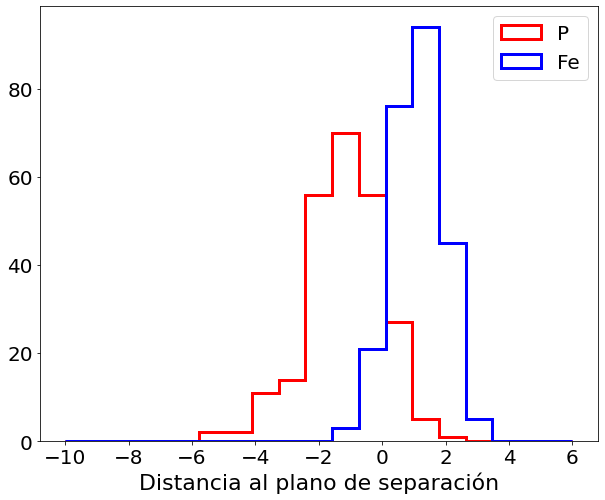

In [754]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [755]:
boostMF(c1_pred, c2_pred)

('1.65', '0.09')

In [254]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [255]:
model_svm_7p = rnd_search_cv.best_estimator_
model_svm_7p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=35.26528770473972, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [256]:
print(accuracy(X_train, y_train, model_svm_7p))
print(crossAccuracy(X_train, y_train, model_svm_7p))

0.8934426229508197
Accuracy:  0.8954931972789115 0.03829590613223513
presicion:  0.8667415181298239 0.0569527901939007
recall:  0.9421666666666667 0.042694326971572646
F1_score:  0.9010433172939406 0.032835126735262656
None


In [257]:
mconfusion(X_train, y_train, model_svm_7p)

Matriz de confusión, 

[[207  37]
 [ 14 230]]
precisión:  0.8614232209737828
exhaustividad:  0.9426229508196722


In [258]:
print(classification_report(y_train, model_svm_7p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       244
           1       0.85      0.95      0.90       244

    accuracy                           0.89       488
   macro avg       0.90      0.89      0.89       488
weighted avg       0.90      0.89      0.89       488



In [259]:
ypred = cross_val_predict(model_svm_7p, X_train, y_train, cv=5, method="decision_function")

In [260]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

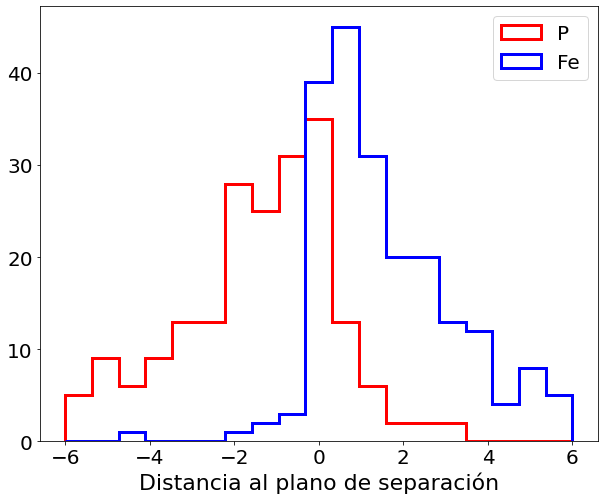

In [261]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [262]:
boostMF(c1_pred, c2_pred)

('0.83', '0.06')

In [745]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [746]:
model_svm_8 = rnd_search_cv.best_estimator_
model_svm_8

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.347823229140562, break_ties=False, cache_size=200,
                     class_weight=None, coef0=70.52644469271883,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00913631456135275, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [747]:
print(accuracy(X_train, y_train, model_svm_8))
print(crossAccuracy(X_train, y_train, model_svm_8))

0.8954918032786885
Accuracy:  0.8893707482993198 0.04786508656253189
presicion:  0.8559175498830672 0.04371251395066402
recall:  0.9383333333333332 0.062128898268036276
F1_score:  0.8943252246117661 0.045851140434677785
None


In [748]:
mconfusion(X_train, y_train, model_svm_8)

Matriz de confusión, 

[[205  39]
 [ 15 229]]
precisión:  0.8544776119402985
exhaustividad:  0.9385245901639344


In [749]:
print(classification_report(y_train, model_svm_8.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       244
           1       0.86      0.95      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [750]:
ypred = cross_val_predict(model_svm_8, X_train, y_train, cv=5, method="decision_function")

In [751]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

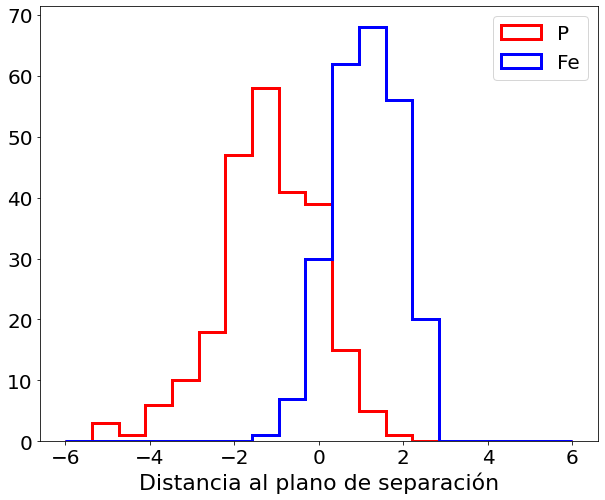

In [752]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [753]:
boostMF(c1_pred, c2_pred)

('1.65', '0.09')

## Sumando el ángulo cenital

In [756]:
#Features

df_train_2 = df_train[["GeoCeXmax", "LogSrad", "N_mu_ref", "MC energy", "MC zenith", "target"]]
df_test_2 = df_test[["GeoCeXmax", "LogSrad", "N_mu_ref", "MC energy", "MC zenith", "target"]]

In [757]:
print(df_train_2.shape, df_test_.shape)

(488, 6) (122, 64)


In [758]:
df_train_2.head()

,GeoCeXmax,LogSrad,N_mu_ref,MC energy,MC zenith,target
246,610.506,3.074320,0.850606,3.824250e+17,50.0277,1
76,670.556,3.352450,1.114180,7.590210e+17,50.6696,1
171,669.154,3.271228,1.146870,6.116010e+17,40.6307,1
191,571.015,3.122918,0.612265,3.842740e+17,53.6568,1
75,599.145,3.448698,1.232080,9.452550e+17,49.0955,1


In [759]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC zenith    0.016190
MC energy   -0.005095
LogSrad     -0.060095
GeoCeXmax   -0.461443
Name: target, dtype: float64

In [760]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 5) (488,) (488, 5) (122,)


In [761]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [762]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [763]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 5) (122, 5) (488,) (122,)


In [764]:
X_train.head()

,GeoCeXmax,LogSrad,N_mu_ref,MC energy,MC zenith
0,-0.751797,-0.187830,0.462230,-0.324464,0.607596
1,0.260940,1.099993,1.066291,1.092195,0.757615
2,0.238489,0.723505,1.133262,0.651643,-1.051059
3,-1.481640,0.036905,-0.224563,-0.314309,1.527753
4,-0.956135,1.546554,1.301173,1.534527,0.398978


In [765]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [766]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [283]:
model_Log_9 = rnd_search_cv.best_estimator_
model_Log_9

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.6341658380750957, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [284]:
print(accuracy(X_train, y_train, model_Log_9))
print(crossAccuracy(X_train, y_train, model_Log_9))

0.8975409836065574
Accuracy:  0.8934098639455783 0.04841716440087553
presicion:  0.8793466131292218 0.04687854438883702
recall:  0.9136666666666666 0.06511442919114695
F1_score:  0.8951749870299175 0.047737099948115196
None


In [285]:
mconfusion(X_train, y_train, model_Log_9)

Matriz de confusión, 

[[213  31]
 [ 21 223]]
precisión:  0.8779527559055118
exhaustividad:  0.9139344262295082


In [286]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [287]:
ypred = cross_val_predict(model_Log_9, X_train, y_train, cv=5, method="decision_function")

In [288]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

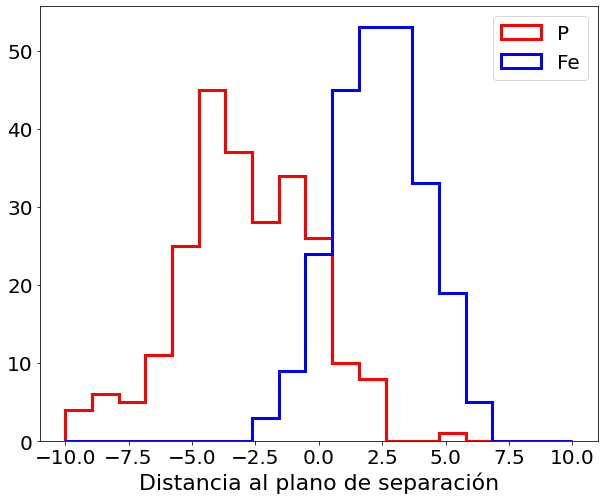

In [289]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [290]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [291]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 55)

In [292]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 55)

In [293]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [294]:
model_Log_10 = rnd_search_cv.best_estimator_
model_Log_10

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=6.496706876788005, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [295]:
print(accuracy(X_poly2, y_train, model_Log_10))
print(crossAccuracy(X_poly2, y_train, model_Log_10))

0.9180327868852459
Accuracy:  0.8871598639455781 0.046612370115712363
presicion:  0.8844454896954896 0.04934949212011207
recall:  0.8966666666666667 0.09902019995940221
F1_score:  0.8858407346462853 0.054862085331466054
None


In [296]:
mconfusion(X_poly2, y_train, model_Log_10)

Matriz de confusión, 

[[214  30]
 [ 25 219]]
precisión:  0.8795180722891566
exhaustividad:  0.8975409836065574


In [297]:
print(classification_report(y_train, model_Log_10.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       244
           1       0.91      0.93      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [298]:
ypred = cross_val_predict(model_Log_10, X_poly2, y_train, cv=5, method="decision_function")

In [299]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

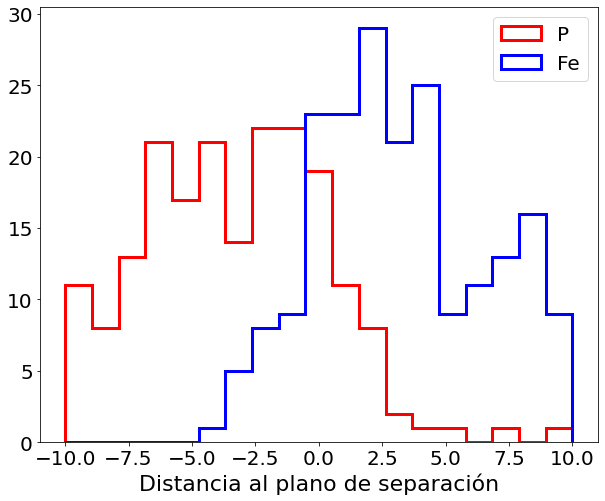

In [300]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [301]:
boostMF(c1_pred, c2_pred)

('1.18', '0.07')

## SVM

In [302]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [303]:
model_svm_9 = rnd_search_cv.best_estimator_
model_svm_9

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.6250745163334486, break_ties=False, cache_size=200,
                     class_weight=None, coef0=37.772089745565395,
                     decision_function_shape='ovr', degree=3,
                     gamma=1.0312305559868608e-05, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [304]:
print(accuracy(X_train, y_train, model_svm_9))
print(crossAccuracy(X_train, y_train, model_svm_9))

0.8995901639344263
Accuracy:  0.8975340136054422 0.04598642286055565
presicion:  0.8840753473579561 0.049460194400780956
recall:  0.9176666666666666 0.06159996392495337
F1_score:  0.899373291896131 0.045316651239886985
None


In [305]:
mconfusion(X_train, y_train, model_svm_9)

Matriz de confusión, 

[[214  30]
 [ 20 224]]
precisión:  0.8818897637795275
exhaustividad:  0.9180327868852459


In [306]:
print(classification_report(y_train, model_svm_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.88      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [307]:
ypred = cross_val_predict(model_svm_9, X_train, y_train, cv=5, method="decision_function")

In [308]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

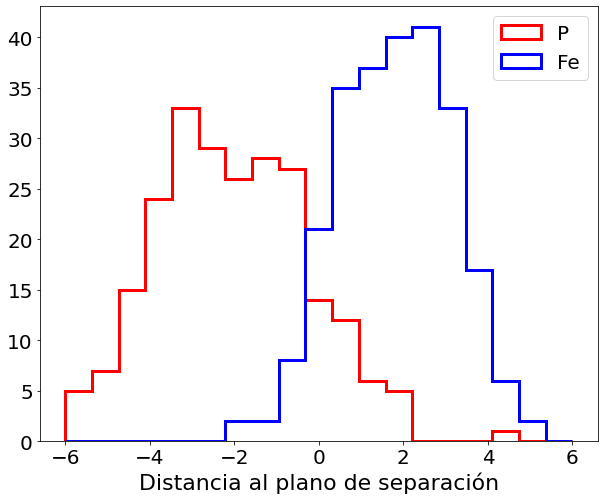

In [309]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [310]:
boostMF(c1_pred, c2_pred)

('1.66', '0.09')

In [311]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [312]:
model_svm_9p = rnd_search_cv.best_estimator_
model_svm_9p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=6.507790069407081, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [313]:
print(accuracy(X_train, y_train, model_svm_9p))
print(crossAccuracy(X_train, y_train, model_svm_9p))

0.8954918032786885
Accuracy:  0.8666666666666666 0.04075569476232964
presicion:  0.8734533984533984 0.05313928076188273
recall:  0.8643333333333334 0.08164693639214042
F1_score:  0.8652683458042582 0.04496582586817563
None


In [314]:
mconfusion(X_train, y_train, model_svm_9p)

Matriz de confusión, 

[[212  32]
 [ 33 211]]
precisión:  0.8683127572016461
exhaustividad:  0.8647540983606558


In [315]:
print(classification_report(y_train, model_svm_9p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       244
           1       0.90      0.89      0.89       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [316]:
ypred = cross_val_predict(model_svm_9p, X_train, y_train, cv=5, method="decision_function")

In [317]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

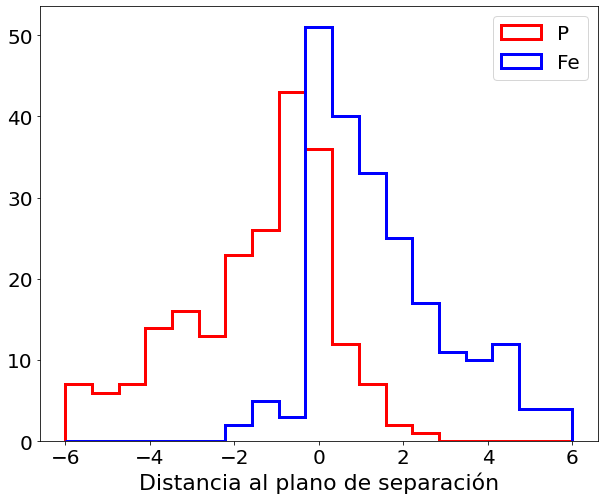

In [318]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [319]:
boostMF(c1_pred, c2_pred)

('0.96', '0.08')

In [320]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [321]:
model_svm_10 = rnd_search_cv.best_estimator_
model_svm_10

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=60.303132599235816, break_ties=False, cache_size=200,
                     class_weight=None, coef0=78.02841857726771,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.014914847658148895, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [322]:
print(accuracy(X_train, y_train, model_svm_10))
print(crossAccuracy(X_train, y_train, model_svm_10))

0.9077868852459017
Accuracy:  0.9036989795918368 0.05440623781897346
presicion:  0.8953823326432022 0.05842628121750408
recall:  0.9175000000000001 0.07390778789215052
F1_score:  0.9045805607097688 0.05470587327641323
None


In [323]:
mconfusion(X_train, y_train, model_svm_10)

Matriz de confusión, 

[[217  27]
 [ 20 224]]
precisión:  0.8924302788844621
exhaustividad:  0.9180327868852459


In [324]:
print(classification_report(y_train, model_svm_10.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       244
           1       0.89      0.93      0.91       244

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488



In [325]:
ypred = cross_val_predict(model_svm_10, X_train, y_train, cv=5, method="decision_function")

In [326]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

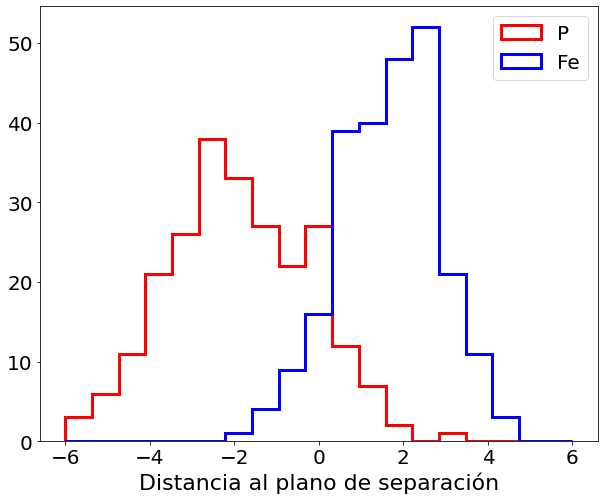

In [327]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [328]:
boostMF(c1_pred, c2_pred)

('1.68', '0.09')

In [329]:
"Stations with Pulse"

'Stations with Pulse'

## Sumando estaciones de Radio

In [330]:
#Features

df_train_2 = df_train[["GeoCeXmax", "LogSrad", "N_mu_ref", "MC energy", "MC zenith", "Stations with Pulse", "target"]]
df_test_2 = df_test[["GeoCeXmax", "LogSrad", "N_mu_ref", "MC energy", "MC zenith", "Stations with Pulse", "target"]]

In [331]:
print(df_train_2.shape, df_test_.shape)

(488, 7) (122, 64)


In [332]:
df_train_2.head()

,GeoCeXmax,LogSrad,N_mu_ref,MC energy,MC zenith,Stations with Pulse,target
246,610.506,3.074320,0.850606,3.824250e+17,50.0277,5,1
76,670.556,3.352450,1.114180,7.590210e+17,50.6696,6,1
171,669.154,3.271228,1.146870,6.116010e+17,40.6307,7,1
191,571.015,3.122918,0.612265,3.842740e+17,53.6568,31,1
75,599.145,3.448698,1.232080,9.452550e+17,49.0955,9,1


In [333]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
N_mu_ref               0.384449
Stations with Pulse    0.031046
MC zenith              0.016190
MC energy             -0.005095
LogSrad               -0.060095
GeoCeXmax             -0.461443
Name: target, dtype: float64

In [334]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 6) (488,) (488, 6) (122,)


In [335]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [336]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [337]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 6) (122, 6) (488,) (122,)


In [338]:
X_train.head()

,GeoCeXmax,LogSrad,N_mu_ref,MC energy,MC zenith,Stations with Pulse
0,-0.751797,-0.187830,0.462230,-0.324464,0.607596,-1.310774
1,0.260940,1.099993,1.066291,1.092195,0.757615,-0.712103
2,0.238489,0.723505,1.133262,0.651643,-1.051059,-0.284582
3,-1.481640,0.036905,-0.224563,-0.314309,1.527753,1.699532
4,-0.956135,1.546554,1.301173,1.534527,0.398978,0.285287


In [339]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

In [340]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [341]:
model_Log_11 = rnd_search_cv.best_estimator_
model_Log_11

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=35.141487153590916, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [342]:
print(accuracy(X_train, y_train, model_Log_11))
print(crossAccuracy(X_train, y_train, model_Log_11))

0.9016393442622951
Accuracy:  0.8954506802721088 0.054047277224787416
presicion:  0.8866807934416631 0.05548861433444028
recall:  0.9095000000000001 0.07357177145859378
F1_score:  0.8964647193890963 0.0542785611673059
None


In [343]:
mconfusion(X_train, y_train, model_Log_11)

Matriz de confusión, 

[[215  29]
 [ 22 222]]
precisión:  0.8844621513944223
exhaustividad:  0.9098360655737705


In [344]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_11.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       244
           1       0.89      0.92      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [345]:
ypred = cross_val_predict(model_Log_11, X_train, y_train, cv=5, method="decision_function")

In [346]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

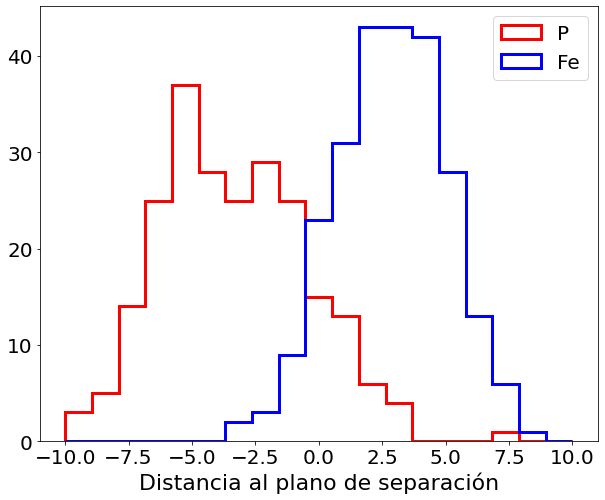

In [347]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [348]:
boostMF(c1_pred, c2_pred)

('1.63', '0.09')

In [349]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 83)

In [350]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 83)

In [351]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=500, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [352]:
model_Log_12 = rnd_search_cv.best_estimator_
model_Log_12

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.0489561667078706, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [353]:
print(accuracy(X_poly2, y_train, model_Log_12))
print(crossAccuracy(X_poly2, y_train, model_Log_12))

0.930327868852459
Accuracy:  0.8851190476190475 0.04999313028377362
presicion:  0.884749437538418 0.055138275282973076
recall:  0.8925000000000001 0.10070653184156207
F1_score:  0.8837108447170288 0.05731480597780944
None


In [354]:
mconfusion(X_poly2, y_train, model_Log_12)

Matriz de confusión, 

[[214  30]
 [ 26 218]]
precisión:  0.8790322580645161
exhaustividad:  0.8934426229508197


In [355]:
print(classification_report(y_train, model_Log_12.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       244
           1       0.92      0.94      0.93       244

    accuracy                           0.93       488
   macro avg       0.93      0.93      0.93       488
weighted avg       0.93      0.93      0.93       488



In [356]:
ypred = cross_val_predict(model_Log_12, X_poly2, y_train, cv=5, method="decision_function")

In [357]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

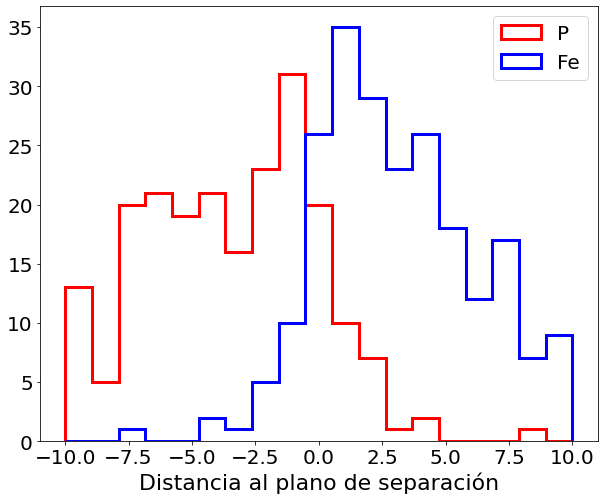

In [358]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [359]:
boostMF(c1_pred, c2_pred)

('1.16', '0.09')

## SVM

In [360]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [361]:
model_svm_11 = rnd_search_cv.best_estimator_
model_svm_11

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.0652601856330675, break_ties=False, cache_size=200,
                     class_weight=None, coef0=12.443429845226817,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.00040909772970963417, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [362]:
print(accuracy(X_train, y_train, model_svm_11))
print(crossAccuracy(X_train, y_train, model_svm_11))

0.9016393442622951
Accuracy:  0.8975340136054424 0.0450716370008585
presicion:  0.8772128427128427 0.04359612070463327
recall:  0.9258333333333333 0.06102936451687281
F1_score:  0.8999687674022091 0.04472306158505926
None


In [363]:
mconfusion(X_train, y_train, model_svm_11)

Matriz de confusión, 

[[212  32]
 [ 18 226]]
precisión:  0.875968992248062
exhaustividad:  0.9262295081967213


In [364]:
print(classification_report(y_train, model_svm_11.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       244
           1       0.88      0.93      0.90       244

    accuracy                           0.90       488
   macro avg       0.90      0.90      0.90       488
weighted avg       0.90      0.90      0.90       488



In [365]:
ypred = cross_val_predict(model_svm_11, X_train, y_train, cv=5, method="decision_function")

In [366]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

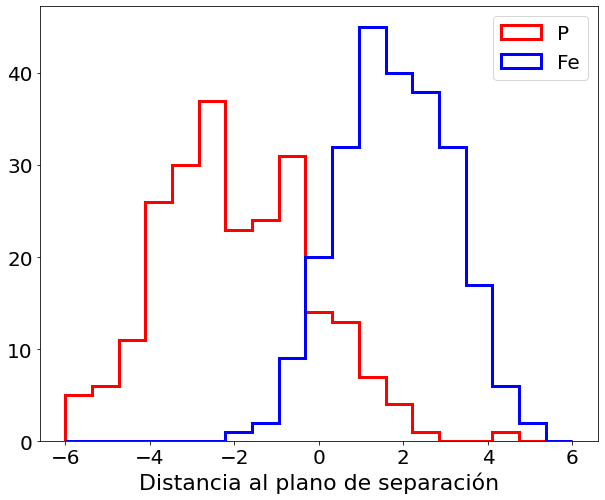

In [367]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [368]:
boostMF(c1_pred, c2_pred)

('1.63', '0.09')

In [369]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [370]:
model_svm_11p = rnd_search_cv.best_estimator_
model_svm_11p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=6.547735044663293, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [371]:
print(accuracy(X_train, y_train, model_svm_11p))
print(crossAccuracy(X_train, y_train, model_svm_11p))

0.9200819672131147
Accuracy:  0.8811224489795919 0.04935351001131853
presicion:  0.8652999469033558 0.06692536013324515
recall:  0.9133333333333333 0.07554615954648006
F1_score:  0.885065190767356 0.0480127439517234
None


In [372]:
mconfusion(X_train, y_train, model_svm_11p)

Matriz de confusión, 

[[207  37]
 [ 21 223]]
precisión:  0.8576923076923076
exhaustividad:  0.9139344262295082


In [373]:
print(classification_report(y_train, model_svm_11p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       244
           1       0.90      0.95      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [374]:
ypred = cross_val_predict(model_svm_11p, X_train, y_train, cv=5, method="decision_function")

In [375]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

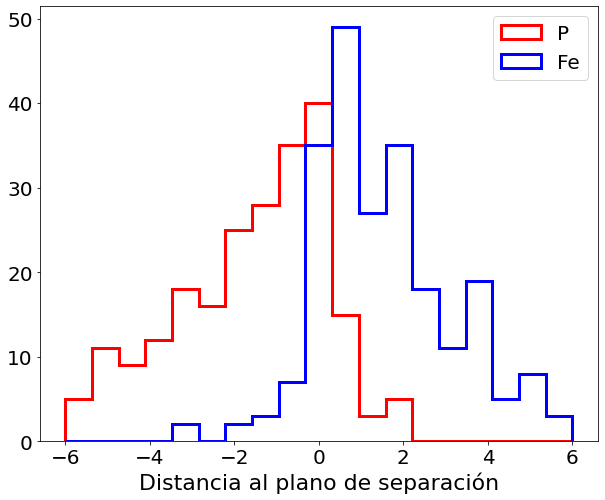

In [376]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [377]:
boostMF(c1_pred, c2_pred)

('0.99', '0.10')

In [378]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=500, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [379]:
model_svm_12 = rnd_search_cv.best_estimator_
model_svm_12

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=89.2979642461809, break_ties=False, cache_size=200,
                     class_weight=None, coef0=73.41802249206772,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0238048473172264, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [380]:
print(accuracy(X_train, y_train, model_svm_12))
print(crossAccuracy(X_train, y_train, model_svm_12))

0.9159836065573771
Accuracy:  0.9017431972789115 0.0445980703429486
presicion:  0.8941249567523929 0.06091456479450316
recall:  0.9174999999999999 0.061487351906261555
F1_score:  0.9034582361822425 0.042698903561438975
None


In [381]:
mconfusion(X_train, y_train, model_svm_12)

Matriz de confusión, 

[[216  28]
 [ 20 224]]
precisión:  0.8888888888888888
exhaustividad:  0.9180327868852459


In [382]:
print(classification_report(y_train, model_svm_12.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       244
           1       0.90      0.93      0.92       244

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488



In [383]:
ypred = cross_val_predict(model_svm_12, X_train, y_train, cv=5, method="decision_function")

In [384]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

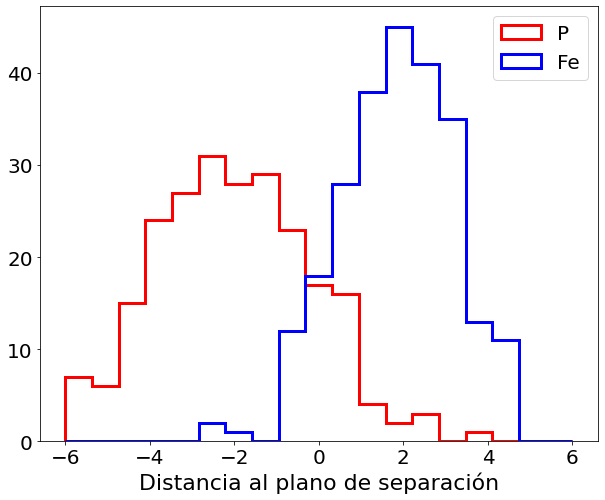

In [385]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [386]:
boostMF(c1_pred, c2_pred)

('1.64', '0.09')

In [387]:
"Stations with Pulse"

'Stations with Pulse'